导入库文件

In [1]:
#导入外部库
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
#导入自定义文件
from utils import *
from conv import *
from concat import *
from relu import *
# np.set_printoptions(threshold=np.inf)
# np.set_printoptions(precision=32, suppress=False, formatter={'float': '{:0.16}'.format})

加载FP32、INT8权重

In [2]:
from weights import w_conv1,w_conv2,w_conv3,w_conv4,w_conv5
from bias import b_conv1,b_conv2,b_conv3,b_conv4,b_conv5
from weights_int8 import qw1,Sw1,qw2,Sw2,qw3,Sw3,qw4,Sw4,qw5,Sw5
from bias_int8 import qb1,Sb1,qb2,Sb2,qb3,Sb3,qb4,Sb4,qb5,Sb5
from inout_int8 import Sconcat1,Zconcat1,Sconcat2,Zconcat2,Sconcat3,Zconcat3,Smul_out,Zmul_out,Ssub_out,Zsub_out,Sadd_out,Zadd_out
from inout_int8 import Sy1,Zy1,Sy2,Zy2,Sy3,Zy3,Sy4,Zy4,Sy5,Zy5
from inout_int8 import Sx1,Zx1,Sx2,Zx2,Sx3,Zx3,Sx4,Zx4,Sx5,Zx5

INT8权重解量化，与FP32权重计算量化误差

In [3]:
Z_3 = np.array([0,0,0])
dqw1 = dequantization_weights(qw1,Sw1,Z_3)
dqw2 = dequantization_weights(qw2,Sw2,Z_3)
dqw3 = dequantization_weights(qw3,Sw3,Z_3)
dqw4 = dequantization_weights(qw4,Sw4,Z_3)
dqw5 = dequantization_weights(qw5,Sw5,Z_3)

dqb1 = dequantization(qb1,Sb1,Z_3)
dqb2 = dequantization(qb2,Sb2,Z_3)
dqb3 = dequantization(qb3,Sb3,Z_3)
dqb4 = dequantization(qb4,Sb4,Z_3)
dqb5 = dequantization(qb5,Sb5,Z_3)

#filter_shape=(output_channel,input_channel,filter_size)
#               输出通道数      输入通道数     卷积核大小
conv1_shape = (3,3,1)
conv2_shape = (3,3,3)
conv3_shape = (3,6,5)
conv4_shape = (3,6,7)
conv5_shape = (3,6,3)

定义图像加载函数

In [ ]:
def array_show(array):
    deahze_img = array*255.0
    deahze_img = deahze_img.astype(np.uint8)
    print(f"deahze_img.shape:{deahze_img.shape:}")
    deahze_img = np.squeeze(deahze_img)
    print(f"deahze_img.shape after:{deahze_img.shape:}")
    img = Image.fromarray(deahze_img.transpose(1,2,0))
    img.show()

def visualize_channels_int8(image):
    num_channels = image.shape[1]  # 获取通道数量
    # 创建子图布局
    fig, axs = plt.subplots(1, num_channels, figsize=(15, 8))
    for i in range(num_channels):
        channel_data = image[0, i]  # 获取当前通道的数据
        axs[i].imshow(channel_data)  # 在子图中显示当前通道的图像
        axs[i].set_title("Channel {}".format(i + 1))  # 设置子图标题
    plt.show()  # 显示图像

定义SSIM和PSNR用于评估推理结果

In [ ]:
#去雾结果评价指标
def PSNR(imageA, imageB):
	# 为确保图像能被转为灰度图
	imageA = np.array(imageA, dtype=np.uint8)
	imageB = np.array(imageB, dtype=np.uint8)
	# print(imageA.shape)
	# print(imageB.shape)
	sub_imageA = [np.squeeze(a) for a in np.split(imageA,indices_or_sections= imageA.shape[0], axis=0)]
	sub_imageB = [np.squeeze(a) for a in np.split(imageB,indices_or_sections= imageB.shape[0], axis=0)]
	grayScore_sum,aveScore,cnt = 0,0,0
	for (sub_imageA_ins,sub_imageB_ins)in zip(sub_imageA,sub_imageB):
		cnt += 1
		# 通道分离，注意顺序BGR不是RGB
		# print("sub_imageA_ins:",sub_imageA_ins.shape)
		# print("sub_imageB_ins:",sub_imageB_ins.shape)
		sub_imageA_ins = np.transpose(sub_imageA_ins,(1,2,0))
		sub_imageB_ins = np.transpose(sub_imageB_ins,(1,2,0))
		# print("sub_imageA_ins:",sub_imageA_ins.shape)
		# print("sub_imageB_ins:",sub_imageB_ins.shape)
		(B1, G1, R1) = cv2.split(sub_imageA_ins)
		(B2, G2, R2) = cv2.split(sub_imageB_ins)

		# convert the images to grayscale BGR2GRAY
		grayA = cv2.cvtColor(sub_imageA_ins, cv2.COLOR_BGR2GRAY)
		grayB = cv2.cvtColor(sub_imageB_ins, cv2.COLOR_BGR2GRAY)

		# 方法一
		grayScore= psnr(grayA, grayB)
		grayScore_sum += grayScore
		# diff = (diff * 255).astype("uint8")

		# 方法二
		score0 = psnr(B1, B2)
		score1 = psnr(G1, G2)
		score2 = psnr(R1, R2)
		aveScore += (score0+score1+score2)/3

	return grayScore_sum/cnt, aveScore/cnt


def SSIM(imageA, imageB):
	# 为确保图像能被转为灰度图
	imageA = np.array(imageA, dtype=np.uint8)
	imageB = np.array(imageB, dtype=np.uint8)
	# print(imageA.shape)
	# print(imageB.shape)
	sub_imageA = [np.squeeze(a) for a in np.split(imageA,indices_or_sections= imageA.shape[0], axis=0)]
	sub_imageB = [np.squeeze(a) for a in np.split(imageB,indices_or_sections= imageB.shape[0], axis=0)]
	grayScore_sum,aveScore,cnt = 0,0,0

	for (sub_imageA_ins,sub_imageB_ins)in zip(sub_imageA,sub_imageB):
		cnt += 1
		# 通道分离，注意顺序BGR不是RGB
		# print("sub_imageA_ins:",sub_imageA_ins.shape)
		# print("sub_imageB_ins:",sub_imageB_ins.shape)
		sub_imageA_ins = np.transpose(sub_imageA_ins,(1,2,0))
		sub_imageB_ins = np.transpose(sub_imageB_ins,(1,2,0))
		# print("sub_imageA_ins:",sub_imageA_ins.shape)
		# print("sub_imageB_ins:",sub_imageB_ins.shape)
		# 通道分离，注意顺序BGR不是RGB
		(B1, G1, R1) = cv2.split(sub_imageA_ins)
		(B2, G2, R2) = cv2.split(sub_imageB_ins)

		# convert the images to grayscale BGR2GRAY
		grayA = cv2.cvtColor(sub_imageA_ins, cv2.COLOR_BGR2GRAY)
		grayB = cv2.cvtColor(sub_imageB_ins, cv2.COLOR_BGR2GRAY)

		# 方法一
		(grayScore, diff) = ssim(grayA, grayB, full=True)
		grayScore_sum += grayScore

		# 方法二
		(score0, diffB) = ssim(B1, B2, full=True)
		(score1, diffG) = ssim(G1, G2, full=True)
		(score2, diffR) = ssim(R1, R2, full=True)
		aveScore += (score0+score1+score2)/3
	
	return grayScore_sum/cnt, aveScore/cnt

加载图像

In [7]:
# img_path="./query_hazy_images/OTS_0947.jpg"
# img_path="./query_hazy_images/OTS_2535.jpg"
# img_path="./query_hazy_images/OTS_2633.jpg"
# img_path="./query_hazy_images/OTS_2987.jpg"
# img_path="./query_hazy_images/OTS_2999.jpg"

img_name = "OTS_2987.jpg"
img_path="./query_hazy_images/" + img_name
clear_img_path="./original_image/" + img_name

hazy_input_image = Image.open(img_path)#图像加载
hazy_input_image = hazy_input_image.resize((640, 480))
hazy_input_image.show()
hazy_image = (np.asarray(hazy_input_image))
hazy_image = hazy_image.transpose(2,0,1)#HWC -> CHW
hazy_image = np.expand_dims(hazy_image,axis=0)#增加一个新的维度batch_size (batch_size,C,H,W)
print(f"haze_image.shape:{hazy_image.shape}")
print(f"haze_image.dtype:{hazy_image.dtype}")
print(f"haze_image:\n{hazy_image}")
visualize_channels_int8(hazy_image)

hazy_image = hazy_image/255.0#图片数值归一化
# array_show(hazy_image)
print(f"haze_image.shape:{hazy_image.shape}")
print(f"haze_image.dtype:{hazy_image.dtype}")
print(f"haze_image:\n{hazy_image}")

2.0619258880615234
0.0055389404296875


In [ ]:
print(f"dqw1.shape:{dqw1.shape}")
print(f"dqw2.shape:{dqw2.shape}")
print(f"dqw3.shape:{dqw3.shape}")
print(f"dqw4.shape:{dqw4.shape}")
print(f"dqw5.shape:{dqw5.shape}")

print(f"dqb1.shape:{dqb1.shape}")
print(f"dqb2.shape:{dqb2.shape}")
print(f"dqb3.shape:{dqb3.shape}")
print(f"dqb4.shape:{dqb4.shape}")
print(f"dqb5.shape:{dqb5.shape}")

dqw1.shape:(3, 3, 1, 1)
dqw2.shape:(3, 3, 3, 3)
dqw3.shape:(3, 6, 5, 5)
dqw4.shape:(3, 6, 7, 7)
dqw5.shape:(3, 6, 3, 3)
dqb1.shape:(1, 3)
dqb2.shape:(1, 3)
dqb3.shape:(1, 3)
dqb4.shape:(1, 3)
dqb5.shape:(1, 3)


定义MSE函数评估量化损失

In [ ]:
def MSE(mat1,mat2):
    return np.sum(np.abs(mat1-mat2))/mat1.size
print("卷积weights量化误差")
print(f"MSE(w_conv1,dqw1):{MSE(w_conv1,dqw1)}")
print(f"MSE(w_conv2,dqw2):{MSE(w_conv2,dqw2)}")
print(f"MSE(w_conv3,dqw3):{MSE(w_conv3,dqw3)}")
print(f"MSE(w_conv4,dqw4):{MSE(w_conv4,dqw4)}")
print(f"MSE(w_conv5,dqw5):{MSE(w_conv5,dqw5)}")
print("偏置bias量化误差")
print(f"MSE(b_conv1,dqb1):{MSE(b_conv1,dqb1)}")
print(f"MSE(b_conv2,dqb2):{MSE(b_conv2,dqb2)}")
print(f"MSE(b_conv3,dqb3):{MSE(b_conv3,dqb3)}")
print(f"MSE(b_conv4,dqb4):{MSE(b_conv4,dqb4)}")
print(f"MSE(b_conv5,dqb5):{MSE(b_conv5,dqb5)}")

卷积weights量化误差
MSE(w_conv1,dqw1):0.0010520124607879626
MSE(w_conv2,dqw2):0.0015840606557374279
MSE(w_conv3,dqw3):0.0041537005558046165
MSE(w_conv4,dqw4):0.0025414098554162744
MSE(w_conv5,dqw5):0.0009562929772375322
偏置bias量化误差
MSE(b_conv1,dqb1):4.863069661455628e-06
MSE(b_conv2,dqb2):3.7813028113074334e-06
MSE(b_conv3,dqb3):6.9844346555075765e-06
MSE(b_conv4,dqb4):2.541747627251197e-06
MSE(b_conv5,dqb5):2.5707125091608183e-06


输入图片量化

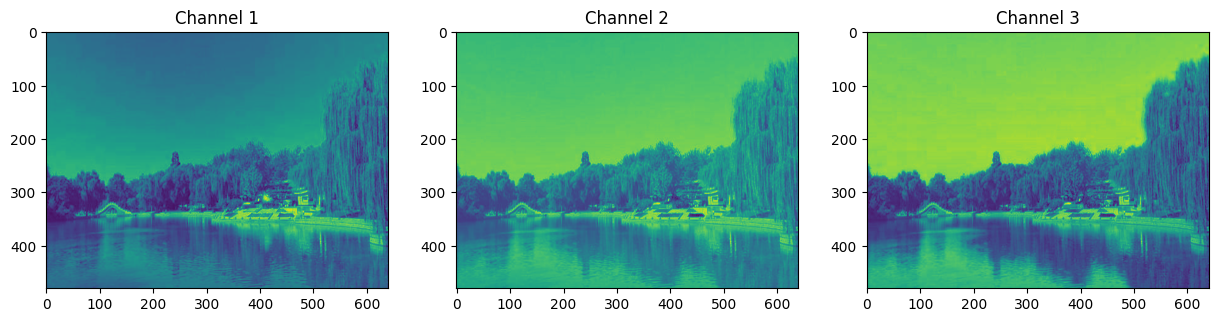

haze_img_int8:[[[[ 13  13  13 ...  26  26  26]
   [ 13  13  13 ...  26  26  26]
   [ 13  13  13 ...  26  26  26]
   ...
   [ -2  -1   0 ...   0 -13 -21]
   [ -2   0   1 ...   1 -12 -20]
   [ -2   0   1 ...   2 -11 -19]]

  [[ 57  57  57 ...  63  63  63]
   [ 57  57  57 ...  63  63  63]
   [ 57  57  57 ...  63  63  63]
   ...
   [ 31  32  33 ...   5  -8 -16]
   [ 31  33  34 ...   6  -7 -15]
   [ 31  33  34 ...   7  -6 -14]]

  [[ 84  84  84 ...  90  90  90]
   [ 84  84  84 ...  90  90  90]
   [ 84  84  84 ...  90  90  90]
   ...
   [ 46  47  48 ... -25 -38 -46]
   [ 46  48  49 ... -24 -37 -45]
   [ 46  48  49 ... -23 -36 -44]]]]


In [ ]:
haze_img_int8 = (hazy_image*255.0-128).astype(np.int8)
visualize_channels_int8(haze_img_int8)
print(f"haze_img_int8:{haze_img_int8}")

conv-relu1计算

In [ ]:
print(f"haze_img_int8.dtype:{haze_img_int8.dtype}")
print(f"qw1.dtype:{qw1.dtype}")

haze_img_int8.dtype:int8
qw1.dtype:int8


量化卷积计算int8*int8+int32 -> int32

M:[[661 472 494]]
B:[[ -48 -100 -107]]
deahze_img.shape:(1, 3, 480, 640)
deahze_img.shape after:(3, 480, 640)



(eog:13886): EOG-WARNING **: 16:34:26.963: Couldn't load icon: Icon 'image-loading' not present in theme Adwaita


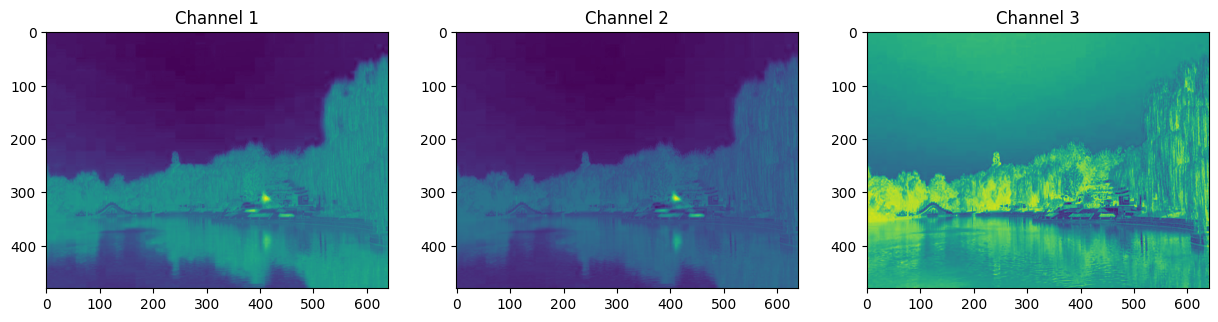

q_conv1:[[[[-146 -146 -146 ... -143 -143 -143]
   [-146 -146 -146 ... -143 -143 -143]
   [-146 -146 -146 ... -143 -143 -143]
   ...
   [-109 -109 -110 ...  -16  -10   -6]
   [-109 -110 -110 ...  -17  -10   -6]
   [-109 -110 -110 ...  -17  -11   -7]]

  [[-168 -168 -168 ... -164 -164 -164]
   [-168 -168 -168 ... -164 -164 -164]
   [-168 -168 -168 ... -164 -164 -164]
   ...
   [-145 -145 -145 ...  -97  -92  -89]
   [-145 -145 -146 ...  -97  -92  -89]
   [-145 -145 -146 ...  -97  -93  -90]]

  [[-120 -120 -120 ... -133 -133 -133]
   [-120 -120 -120 ... -133 -133 -133]
   [-120 -120 -120 ... -133 -133 -133]
   ...
   [-105 -107 -108 ... -128 -112 -102]
   [-105 -108 -109 ... -129 -113 -103]
   [-105 -108 -109 ... -130 -114 -104]]]]
q_conv1.shape:(1, 3, 480, 640)
q_conv1.dtype:int32


In [ ]:
q_conv1 = Q_conv2d_fused(haze_img_int8,qw1,qb1,Sx1,Zx1,Sw1,Sb1,Sy1,Zy1,conv1_shape,stride=1,padding='SAME')
array_show(q_conv1)
visualize_channels_int8(q_conv1)
print(f"q_conv1:{q_conv1}")
print(f"q_conv1.shape:{q_conv1.shape}")
print(f"q_conv1.dtype:{q_conv1.dtype}")

解量化查看卷积计算结果

In [ ]:
dq_conv1 = dequantization(q_conv1,Sy1,Zy1)
print(f"dq_conv1:{dq_conv1}")
print(f"dq_conv1.shape:{dq_conv1.shape}")
print(f"dq_conv1.dtype:{dq_conv1.dtype}")

dq_conv1:[[[[-0.04398158 -0.04398158 -0.04398158 ... -0.03665131 -0.03665131
    -0.03665131]
   [-0.04398158 -0.04398158 -0.04398158 ... -0.03665131 -0.03665131
    -0.03665131]
   [-0.04398158 -0.04398158 -0.04398158 ... -0.03665131 -0.03665131
    -0.03665131]
   ...
   [ 0.046425    0.046425    0.04398158 ...  0.27366313  0.28832367
     0.29809734]
   [ 0.046425    0.04398158  0.04398158 ...  0.27121973  0.28832367
     0.29809734]
   [ 0.046425    0.04398158  0.04398158 ...  0.27121973  0.28588024
     0.29565394]]

  [[-0.09773684 -0.09773684 -0.09773684 ... -0.08796316 -0.08796316
    -0.08796316]
   [-0.09773684 -0.09773684 -0.09773684 ... -0.08796316 -0.08796316
    -0.08796316]
   [-0.09773684 -0.09773684 -0.09773684 ... -0.08796316 -0.08796316
    -0.08796316]
   ...
   [-0.04153816 -0.04153816 -0.04153816 ...  0.07574605  0.08796316
     0.09529342]
   [-0.04153816 -0.04153816 -0.04398158 ...  0.07574605  0.08796316
     0.09529342]
   [-0.04153816 -0.04153816 -0.04398158 

relu1计算

deahze_img.shape:(1, 3, 480, 640)
deahze_img.shape after:(3, 480, 640)



(eog:13886): EOG-WARNING **: 16:34:27.616: Couldn't load icon: Icon 'image-loading' not present in theme Adwaita


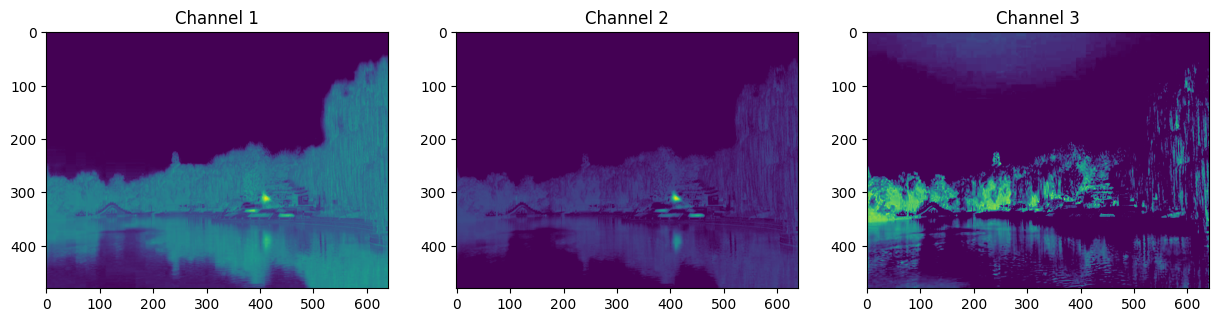

qrelu1:[[[[-128 -128 -128 ... -128 -128 -128]
   [-128 -128 -128 ... -128 -128 -128]
   [-128 -128 -128 ... -128 -128 -128]
   ...
   [-109 -109 -110 ...  -16  -10   -6]
   [-109 -110 -110 ...  -17  -10   -6]
   [-109 -110 -110 ...  -17  -11   -7]]

  [[-128 -128 -128 ... -128 -128 -128]
   [-128 -128 -128 ... -128 -128 -128]
   [-128 -128 -128 ... -128 -128 -128]
   ...
   [-128 -128 -128 ...  -97  -92  -89]
   [-128 -128 -128 ...  -97  -92  -89]
   [-128 -128 -128 ...  -97  -93  -90]]

  [[-120 -120 -120 ... -128 -128 -128]
   [-120 -120 -120 ... -128 -128 -128]
   [-120 -120 -120 ... -128 -128 -128]
   ...
   [-105 -107 -108 ... -128 -112 -102]
   [-105 -108 -109 ... -128 -113 -103]
   [-105 -108 -109 ... -128 -114 -104]]]]
qrelu1.shape:(1, 3, 480, 640)
qrelu1.dtype:int8


In [ ]:
qrelu1 = Q_Relu(Zy1,Sy1,Zy1,Sy1,q_conv1)
array_show(qrelu1)
visualize_channels_int8(qrelu1)
print(f"qrelu1:{qrelu1}")
print(f"qrelu1.shape:{qrelu1.shape}")
print(f"qrelu1.dtype:{qrelu1.dtype}")

打印relu解量化结果

In [ ]:
dqrelu1 = dequantization(qrelu1,Sy1,Zy1)
print(f"dqrelu1:{dqrelu1}")
print(f"dqrelu1.dtype:{dqrelu1.dtype}")
print(f"dqrelu1.shape:{dqrelu1.shape}")

dqrelu1:[[[[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   ...
   [0.046425   0.046425   0.04398158 ... 0.27366313 0.28832367
    0.29809734]
   [0.046425   0.04398158 0.04398158 ... 0.27121973 0.28832367
    0.29809734]
   [0.046425   0.04398158 0.04398158 ... 0.27121973 0.28588024
    0.29565394]]

  [[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   ...
   [0.         0.         0.         ... 0.07574605 0.08796316
    0.09529342]
   [0.         0.         0.         ... 0.07574605 0.08796316
    0.09529342]
   [0.         0.         0.         ... 0.07574605 0.08551973
    0.09284999]]

  [[0.01954737 0.01954737 0.01954737 ... 0.         0.
    0.        ]
   

FP32卷积计算结果

In [ ]:
r_conv1 = conv2d(hazy_image, w_conv1, b_conv1, conv1_shape, stride=1, padding='SAME')
print(f"r_conv1:{r_conv1}")
print(f"r_conv1.shape:{r_conv1.shape}")
print(f"r_conv1.dtype:{r_conv1.dtype}")

r_conv1:[[[[-4.14200613e-02 -4.14200613e-02 -4.14200613e-02 ... -3.49039281e-02
    -3.49039281e-02 -3.49039281e-02]
   [-4.14200613e-02 -4.14200613e-02 -4.14200613e-02 ... -3.49039281e-02
    -3.49039281e-02 -3.49039281e-02]
   [-4.14200613e-02 -4.14200613e-02 -4.14200613e-02 ... -3.49039281e-02
    -3.49039281e-02 -3.49039281e-02]
   ...
   [ 4.88990611e-02  4.76994962e-02  4.64999314e-02 ...  2.75869147e-01
     2.91463489e-01  3.01060008e-01]
   [ 4.88990611e-02  4.64999314e-02  4.53003666e-02 ...  2.74669582e-01
     2.90263925e-01  2.99860443e-01]
   [ 4.88990611e-02  4.64999314e-02  4.53003666e-02 ...  2.73470017e-01
     2.89064360e-01  2.98660878e-01]]

  [[-9.58496437e-02 -9.58496437e-02 -9.58496437e-02 ... -8.67094292e-02
    -8.67094292e-02 -8.67094292e-02]
   [-9.58496437e-02 -9.58496437e-02 -9.58496437e-02 ... -8.67094292e-02
    -8.67094292e-02 -8.67094292e-02]
   [-9.58496437e-02 -9.58496437e-02 -9.58496437e-02 ... -8.67094292e-02
    -8.67094292e-02 -8.67094292e-02]
  

FP32卷积计算与INT8卷积计算误差

In [ ]:
print(f"MSE(r_conv1,dq_conv1):{MSE(r_conv1,dq_conv1)}")

MSE(r_conv1,dq_conv1):0.0014404736797878981


FP32 ReLU计算结果

In [ ]:
r_relu1 = Relu(r_conv1)
print(f"r_relu1:{r_relu1}")
print(f"r_relu1.shape:{r_relu1.shape}")

r_relu1:[[[[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   ...
   [0.04889906 0.0476995  0.04649993 ... 0.27586915 0.29146349
    0.30106001]
   [0.04889906 0.04649993 0.04530037 ... 0.27466958 0.29026392
    0.29986044]
   [0.04889906 0.04649993 0.04530037 ... 0.27347002 0.28906436
    0.29866088]]

  [[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   ...
   [0.         0.         0.         ... 0.07703894 0.08893565
    0.09625671]
   [0.         0.         0.         ... 0.07612381 0.08802052
    0.09534157]
   [0.         0.         0.         ... 0.07520867 0.08710539
    0.09442644]]

  [[0.01900888 0.01900888 0.01900888 ... 0.         0.
    0.        ]
   

In [ ]:
print(f"MSE(r_relu1,dq_conv1):{MSE(r_relu1,dqrelu1)}")

MSE(r_relu1,dq_conv1):0.00072089186619149


conv-relu2计算

In [ ]:
print(f"qrelu1.dtype:{qrelu1.dtype}")#q_x2
print(f"qw2.dtype:{qw2.dtype}")

qrelu1.dtype:int8
qw2.dtype:int8


M:[[851 335 346]]
B:[[-511 -159  -28]]


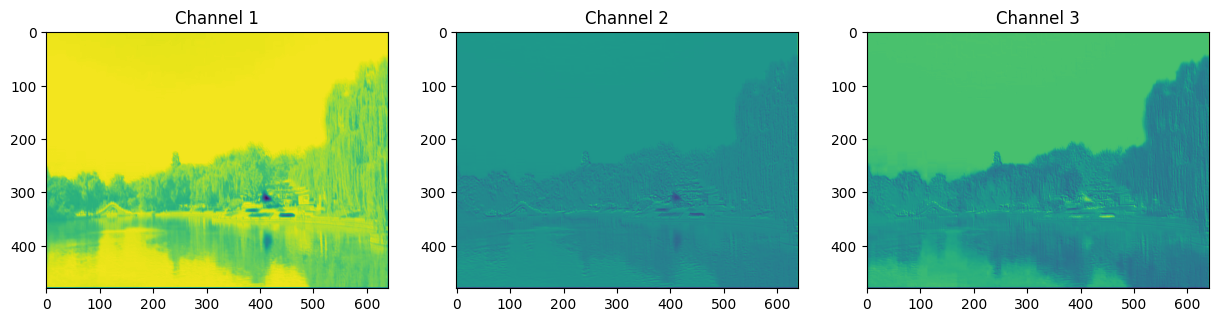

deahze_img.shape:(1, 3, 480, 640)
deahze_img.shape after:(3, 480, 640)
q_conv2:[[[[-521 -303 -303 ... -302 -302 -336]
   [-499  -96  -96 ...  -90  -90 -135]
   [-499  -96  -96 ...  -90  -90 -135]
   ...
   [-505 -113 -112 ... -206 -210 -283]
   [-505 -112 -111 ... -208 -210 -284]
   [-606 -461 -461 ... -476 -474 -491]]

  [[ -27   69   69 ...   74   74  139]
   [-101  -98  -98 ... -100 -100   25]
   [-101  -98  -98 ... -100 -100   25]
   ...
   [ -97  -97  -97 ... -136 -141  -92]
   [ -99 -100 -101 ... -134 -137  -87]
   [-226 -339 -343 ... -305 -296 -250]]

  [[-108   14   14 ...   15   15   14]
   [-237  -73  -73 ...  -74  -74  -58]
   [-237  -73  -73 ...  -74  -74  -58]
   ...
   [-227  -97  -96 ... -166 -154 -132]
   [-228  -97  -96 ... -166 -153 -129]
   [-284 -262 -262 ... -254 -237 -179]]]]
q_conv2.shape:(1, 3, 480, 640)
q_conv2.dtype:int32


In [ ]:
q_conv2 = Q_conv2d_fused(qrelu1,qw2,qb2,Sx2,Zx2,Sw2,Sb2,Sy2,Zy2,conv2_shape,stride=1,padding='SAME')
visualize_channels_int8(q_conv2)
array_show(q_conv2)
print(f"q_conv2:{q_conv2}")
print(f"q_conv2.shape:{q_conv2.shape}")
print(f"q_conv2.dtype:{q_conv2.dtype}")

In [ ]:
dq_conv2 = dequantization(q_conv2,Sy2,Zy2)
print(f"dq_conv2:{dq_conv2}")
print(f"dq_conv2.shape:{dq_conv2.shape}")
print(f"dq_conv2.dtype:{dq_conv2.dtype}")

dq_conv2:[[[[-0.7147642  -0.3182792  -0.3182792  ... -0.31646046 -0.31646046
    -0.37829757]
   [-0.67475194  0.05819963  0.05819963 ...  0.06911206  0.06911206
    -0.01273117]
   [-0.67475194  0.05819963  0.05819963 ...  0.06911206  0.06911206
    -0.01273117]
   ...
   [-0.68566436  0.02728107  0.02909981 ... -0.14186159 -0.14913654
    -0.28190443]
   [-0.68566436  0.02909981  0.03091855 ... -0.14549907 -0.14913654
    -0.28372318]
   [-0.86935693 -0.6056399  -0.6056399  ... -0.6329209  -0.6292834
    -0.660202  ]]

  [[ 0.18369257  0.35829145  0.35829145 ...  0.36738515  0.36738515
     0.48560312]
   [ 0.04910593  0.05456215  0.05456215 ...  0.05092467  0.05092467
     0.27826697]
   [ 0.04910593  0.05456215  0.05456215 ...  0.05092467  0.05092467
     0.27826697]
   ...
   [ 0.05638089  0.05638089  0.05638089 ... -0.01454991 -0.0236436
     0.06547458]
   [ 0.05274341  0.05092467  0.04910593 ... -0.01091243 -0.01636864
     0.07456827]
   [-0.17823635 -0.38375378 -0.39102873 ..

relu2计算

deahze_img.shape:(1, 3, 480, 640)
deahze_img.shape after:(3, 480, 640)



(eog:13886): EOG-WARNING **: 16:34:29.045: Couldn't load icon: Icon 'image-loading' not present in theme Adwaita

(eog:13886): EOG-WARNING **: 16:34:29.231: Couldn't load icon: Icon 'image-loading' not present in theme Adwaita


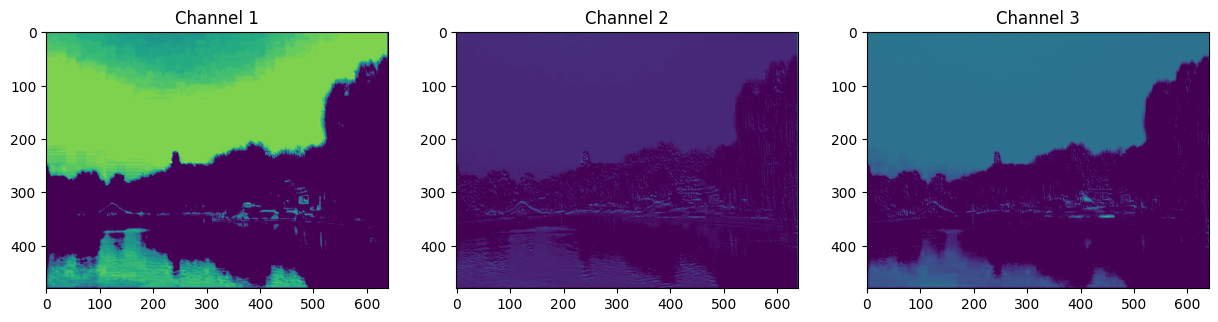

qrelu2:[[[[-128 -128 -128 ... -128 -128 -128]
   [-128  -96  -96 ...  -90  -90 -128]
   [-128  -96  -96 ...  -90  -90 -128]
   ...
   [-128 -113 -112 ... -128 -128 -128]
   [-128 -112 -111 ... -128 -128 -128]
   [-128 -128 -128 ... -128 -128 -128]]

  [[ -27   69   69 ...   74   74  127]
   [-101  -98  -98 ... -100 -100   25]
   [-101  -98  -98 ... -100 -100   25]
   ...
   [ -97  -97  -97 ... -128 -128  -92]
   [ -99 -100 -101 ... -128 -128  -87]
   [-128 -128 -128 ... -128 -128 -128]]

  [[-108   14   14 ...   15   15   14]
   [-128  -73  -73 ...  -74  -74  -58]
   [-128  -73  -73 ...  -74  -74  -58]
   ...
   [-128  -97  -96 ... -128 -128 -128]
   [-128  -97  -96 ... -128 -128 -128]
   [-128 -128 -128 ... -128 -128 -128]]]]
qrelu2.shape:(1, 3, 480, 640)
qrelu2.dtype:int8


In [ ]:
qrelu2 = Q_Relu(Zy2,Sy2,Zy2,Sy2,q_conv2)
array_show(qrelu2)
visualize_channels_int8(qrelu2)
print(f"qrelu2:{qrelu2}")
print(f"qrelu2.shape:{qrelu2.shape}")
print(f"qrelu2.dtype:{qrelu2.dtype}")

In [ ]:
dqrelu2 = dequantization(qrelu2,Sy2,Zy2)
print(f"dqrelu2:{dqrelu2}")
print(f"dqrelu2.dtype:{dqrelu2.dtype}")
print(f"dqrelu2.shape:{dqrelu2.shape}")

dqrelu2:[[[[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.05819963 0.05819963 ... 0.06911206 0.06911206
    0.        ]
   [0.         0.05819963 0.05819963 ... 0.06911206 0.06911206
    0.        ]
   ...
   [0.         0.02728107 0.02909981 ... 0.         0.
    0.        ]
   [0.         0.02909981 0.03091855 ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]]

  [[0.18369257 0.35829145 0.35829145 ... 0.36738515 0.36738515
    0.46377826]
   [0.04910593 0.05456215 0.05456215 ... 0.05092467 0.05092467
    0.27826697]
   [0.04910593 0.05456215 0.05456215 ... 0.05092467 0.05092467
    0.27826697]
   ...
   [0.05638089 0.05638089 0.05638089 ... 0.         0.
    0.06547458]
   [0.05274341 0.05092467 0.04910593 ... 0.         0.
    0.07456827]
   [0.         0.         0.         ... 0.         0.
    0.        ]]

  [[0.03637477 0.25826085 0.25826085 ... 0.26007956 0.26007956
    0.25826085]
   

FP32计算结果

In [ ]:
r_conv2 = conv2d(r_relu1, w_conv2, b_conv2, (3,3,3), stride=1, padding='SAME')
print(f"r_conv2:{r_conv2}")
print(f"r_conv2.shape:{r_conv2.shape}")
print(f"r_conv2.dtype:{r_conv2.dtype}")

r_conv2:[[[[ 0.06846791  0.06627964  0.06627964 ...  0.06817713  0.06817713
     0.06817713]
   [ 0.066356    0.05914777  0.05914777 ...  0.06817713  0.06817713
     0.06817713]
   [ 0.066356    0.05914777  0.05914777 ...  0.06817713  0.06817713
     0.06817713]
   ...
   [ 0.05318676  0.02633312  0.02913329 ... -0.14586539 -0.15140119
    -0.20303436]
   [ 0.0529292   0.02780209  0.0302085  ... -0.14800194 -0.15403626
    -0.20687566]
   [ 0.07017638  0.05851484  0.05913252 ...  0.03057572  0.03529203
    -0.03677467]]

  [[ 0.04415065  0.04158979  0.04158979 ...  0.05108311  0.05108311
     0.05108311]
   [ 0.05367124  0.0551015   0.0551015  ...  0.05108311  0.05108311
     0.05108311]
   [ 0.05367124  0.0551015   0.0551015  ...  0.05108311  0.05108311
     0.05108311]
   ...
   [ 0.06206205  0.05648201  0.05533755 ... -0.01508255 -0.02468779
    -0.16176054]
   [ 0.05786981  0.05102185  0.0497725  ... -0.01064719 -0.0164314
    -0.15364719]
   [ 0.08548763  0.10571794  0.10050311 ..

In [ ]:
print(f"MSE(r_conv2,dq_conv2):{MSE(r_conv2,dq_conv2)}")

MSE(r_conv2,dq_conv2):0.0038131913389367784


In [ ]:
r_relu2 = Relu(r_conv2)
print(f"r_relu2:{r_relu2}")
print(f"r_relu2.shape:{r_relu2.shape}")

r_relu2:[[[[0.06846791 0.06627964 0.06627964 ... 0.06817713 0.06817713
    0.06817713]
   [0.066356   0.05914777 0.05914777 ... 0.06817713 0.06817713
    0.06817713]
   [0.066356   0.05914777 0.05914777 ... 0.06817713 0.06817713
    0.06817713]
   ...
   [0.05318676 0.02633312 0.02913329 ... 0.         0.
    0.        ]
   [0.0529292  0.02780209 0.0302085  ... 0.         0.
    0.        ]
   [0.07017638 0.05851484 0.05913252 ... 0.03057572 0.03529203
    0.        ]]

  [[0.04415065 0.04158979 0.04158979 ... 0.05108311 0.05108311
    0.05108311]
   [0.05367124 0.0551015  0.0551015  ... 0.05108311 0.05108311
    0.05108311]
   [0.05367124 0.0551015  0.0551015  ... 0.05108311 0.05108311
    0.05108311]
   ...
   [0.06206205 0.05648201 0.05533755 ... 0.         0.
    0.        ]
   [0.05786981 0.05102185 0.0497725  ... 0.         0.
    0.        ]
   [0.08548763 0.10571794 0.10050311 ... 0.16871814 0.18418588
    0.12048501]]

  [[0.10145488 0.09480878 0.09480878 ... 0.09773736 0.0977

In [ ]:
print(f"MSE(r_relu2,dq_conv2):{MSE(r_relu2,dqrelu2)}")

MSE(r_relu2,dq_conv2):0.0012784651874029878


Concat1计算

In [ ]:
q_concat1_1 = quantization_int8(dqrelu2,Sconcat1,Zconcat1)
q_concat1 = requantize(qrelu2,Sy2,Zy2,Sconcat1,Zconcat1)
print(f"MSE(q_concat1,q_concat1_1):{MSE(q_concat1,q_concat1_1)}")
print(f"q_concat1:{q_concat1}")
print(f"q_concat1_1:{q_concat1_1}")
# print(f"q_concat1.shape:{q_concat1.shape}")
# print(f"q_concat1.dtype:{q_concat1.dtype}")

M:[191]
MSE(q_concat1,q_concat1_1):0.006272786458333333
q_concat1:[[[[-128 -128 -128 ... -128 -128 -128]
   [-128 -104 -104 ... -100 -100 -128]
   [-128 -104 -104 ... -100 -100 -128]
   ...
   [-128 -117 -116 ... -128 -128 -128]
   [-128 -116 -115 ... -128 -128 -128]
   [-128 -128 -128 ... -128 -128 -128]]

  [[ -53   19   19 ...   23   23   62]
   [-108 -106 -106 ... -107 -107  -14]
   [-108 -106 -106 ... -107 -107  -14]
   ...
   [-105 -105 -105 ... -128 -128 -101]
   [-106 -107 -108 ... -128 -128  -97]
   [-128 -128 -128 ... -128 -128 -128]]

  [[-113  -22  -22 ...  -21  -21  -22]
   [-128  -87  -87 ...  -88  -88  -76]
   [-128  -87  -87 ...  -88  -88  -76]
   ...
   [-128 -105 -104 ... -128 -128 -128]
   [-128 -105 -104 ... -128 -128 -128]
   [-128 -128 -128 ... -128 -128 -128]]]]
q_concat1_1:[[[[-128 -128 -128 ... -128 -128 -128]
   [-128 -104 -104 ... -100 -100 -128]
   [-128 -104 -104 ... -100 -100 -128]
   ...
   [-128 -117 -116 ... -128 -128 -128]
   [-128 -116 -115 ... -128 -

q_concat1:[[[[-128 -128 -128 ... -128 -128 -128]
   [-128 -128 -128 ... -128 -128 -128]
   [-128 -128 -128 ... -128 -128 -128]
   ...
   [-109 -109 -110 ...  -16  -10   -6]
   [-109 -110 -110 ...  -17  -10   -6]
   [-109 -110 -110 ...  -17  -11   -7]]

  [[-128 -128 -128 ... -128 -128 -128]
   [-128 -128 -128 ... -128 -128 -128]
   [-128 -128 -128 ... -128 -128 -128]
   ...
   [-128 -128 -128 ...  -97  -92  -89]
   [-128 -128 -128 ...  -97  -92  -89]
   [-128 -128 -128 ...  -97  -93  -90]]

  [[-120 -120 -120 ... -128 -128 -128]
   [-120 -120 -120 ... -128 -128 -128]
   [-120 -120 -120 ... -128 -128 -128]
   ...
   [-105 -107 -108 ... -128 -112 -102]
   [-105 -108 -109 ... -128 -113 -103]
   [-105 -108 -109 ... -128 -114 -104]]

  [[-128 -128 -128 ... -128 -128 -128]
   [-128 -104 -104 ... -100 -100 -128]
   [-128 -104 -104 ... -100 -100 -128]
   ...
   [-128 -117 -116 ... -128 -128 -128]
   [-128 -116 -115 ... -128 -128 -128]
   [-128 -128 -128 ... -128 -128 -128]]

  [[ -53   19   19

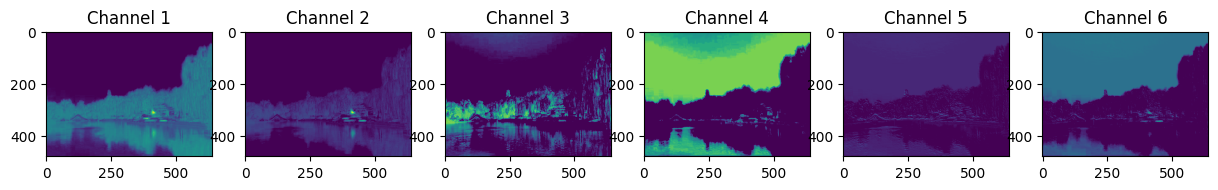

In [ ]:
q_concat1 = concat(qrelu1,q_concat1)
print(f"q_concat1:{q_concat1}")
print(f"q_concat1.shape:{q_concat1.shape}")
print(f"q_concat1.dtype:{q_concat1.dtype}")
visualize_channels_int8(q_concat1)

conv+relu3计算

In [ ]:
print(f"q_concat1.dtype:{q_concat1.dtype}")
print(f"qw3.dtype:{qw3.dtype}")

q_concat1.dtype:int8
qw3.dtype:int8


M:[[ 741  791 2835]]
B:[[  -418     58 -16276]]
deahze_img.shape:(1, 3, 480, 640)
deahze_img.shape after:(3, 480, 640)



(eog:13886): EOG-WARNING **: 16:34:30.895: Couldn't load icon: Icon 'image-loading' not present in theme Adwaita


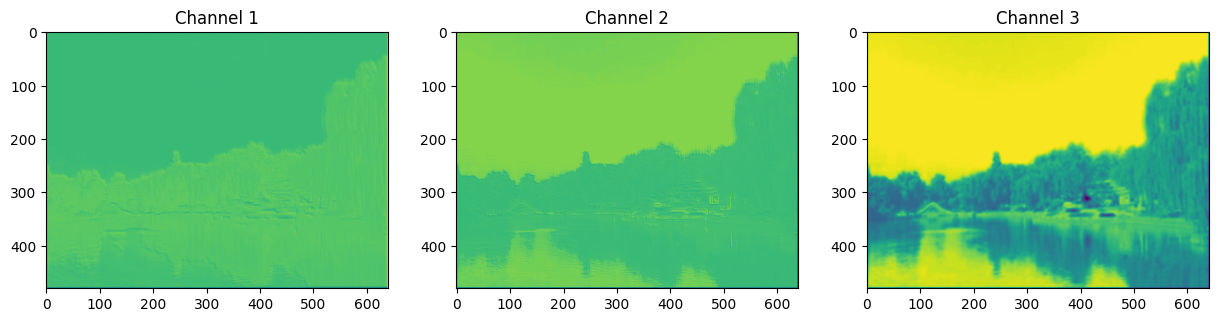

q_conv3:[[[[  -613   -204   -128 ...   -149     65    -90]
   [  -613   -200    -93 ...   -124    206    -66]
   [  -924   -464   -386 ...   -464    -17   -298]
   ...
   [  -801   -276   -103 ...   -123    149    -21]
   [ -1048   -666   -610 ...   -619   -261   -258]
   [  -660   -415   -297 ...   -347   -165   -303]]

  [[  -318   -410   -387 ...   -415   -245   -427]
   [  -242   -351   -251 ...   -269    -94   -477]
   [  -108   -223    -47 ...   -103     72   -504]
   ...
   [   -51   -226    -60 ...   -130    -54   -554]
   [   -86   -248   -120 ...   -176    -95   -458]
   [  -167   -390   -336 ...   -331   -217   -481]]

  [[ -9519  -7888  -5762 ...  -5470  -8035 -10239]
   [ -7996  -6091  -3484 ...  -3118  -6297  -9005]
   [ -6053  -3827   -409 ...     24  -4084  -7372]
   ...
   [ -7328  -5422  -2460 ...  -9946 -11914 -13396]
   [ -9703  -8437  -6312 ... -11799 -13237 -14340]
   [-11698 -10797  -9282 ... -13357 -14304 -15049]]]]
q_conv3.shape:(1, 3, 480, 640)
q_conv3.dtype:i

In [ ]:
q_conv3 = Q_conv2d_fused(q_concat1,qw3,qb3,Sx3,Zx3,Sw3,Sb3,Sy3,Zy3,conv3_shape,stride=1,padding='SAME')
array_show(q_conv3)
visualize_channels_int8(q_conv3)
print(f"q_conv3:{q_conv3}")
print(f"q_conv3.shape:{q_conv3.shape}")
print(f"q_conv3.dtype:{q_conv3.dtype}")

In [ ]:
dq_conv3 = dequantization(q_conv3,Sy3,Zy3)
print(f"dq_conv3:{dq_conv3}")
print(f"dq_conv3.shape:{dq_conv3.shape}")
print(f"dq_conv3.dtype:{dq_conv3.dtype}")

dq_conv3:[[[[-8.59267235e-01 -1.34648055e-01  0.00000000e+00 ... -3.72053832e-02
     3.41935188e-01  6.73240274e-02]
   [-8.59267235e-01 -1.27561316e-01  6.20089732e-02 ...  7.08673988e-03
     5.91742754e-01  1.09844469e-01]
   [-1.41026127e+00 -5.95286131e-01 -4.57094729e-01 ... -5.95286131e-01
     1.96657032e-01 -3.01186442e-01]
   ...
   [-1.19234395e+00 -2.62209386e-01  4.42921259e-02 ...  8.85842461e-03
     4.90756750e-01  1.89570293e-01]
   [-1.62995017e+00 -9.53166485e-01 -8.53952169e-01 ... -8.69897306e-01
    -2.35634103e-01 -2.30319053e-01]
   [-9.42536414e-01 -5.08473575e-01 -2.99414754e-01 ... -3.87998998e-01
    -6.55523464e-02 -3.10044855e-01]]

  [[-3.36620152e-01 -4.99615163e-01 -4.58866417e-01 ... -5.08473575e-01
    -2.07287148e-01 -5.29733777e-01]
   [-2.01972082e-01 -3.95085752e-01 -2.17917249e-01 ... -2.49807581e-01
     6.02372885e-02 -6.18318081e-01]
   [ 3.54336984e-02 -1.68310076e-01  1.43506482e-01 ...  4.42921259e-02
     3.54337007e-01 -6.66153550e-01]
 

relu3的计算

deahze_img.shape:(1, 3, 480, 640)
deahze_img.shape after:(3, 480, 640)



(eog:13886): EOG-WARNING **: 16:34:31.481: Couldn't load icon: Icon 'image-loading' not present in theme Adwaita


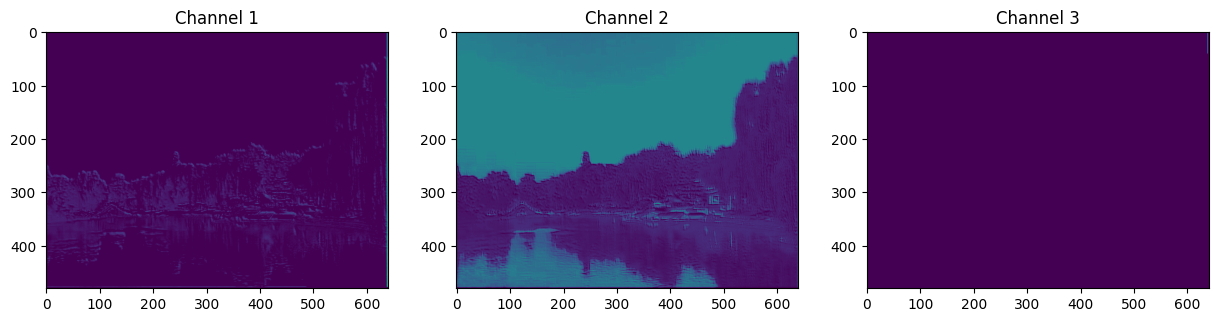

qrelu3:[[[[-128 -128 -128 ... -128   65  -90]
   [-128 -128  -93 ... -124  127  -66]
   [-128 -128 -128 ... -128  -17 -128]
   ...
   [-128 -128 -103 ... -123  127  -21]
   [-128 -128 -128 ... -128 -128 -128]
   [-128 -128 -128 ... -128 -128 -128]]

  [[-128 -128 -128 ... -128 -128 -128]
   [-128 -128 -128 ... -128  -94 -128]
   [-108 -128  -47 ... -103   72 -128]
   ...
   [ -51 -128  -60 ... -128  -54 -128]
   [ -86 -128 -120 ... -128  -95 -128]
   [-128 -128 -128 ... -128 -128 -128]]

  [[-128 -128 -128 ... -128 -128 -128]
   [-128 -128 -128 ... -128 -128 -128]
   [-128 -128 -128 ...   24 -128 -128]
   ...
   [-128 -128 -128 ... -128 -128 -128]
   [-128 -128 -128 ... -128 -128 -128]
   [-128 -128 -128 ... -128 -128 -128]]]]
qrelu3.shape:(1, 3, 480, 640)
qrelu3.dtype:int8


In [ ]:
qrelu3 = Q_Relu(Zy3,Sy3,Zy3,Sy3,q_conv3)
array_show(qrelu3)
visualize_channels_int8(qrelu3)
print(f"qrelu3:{qrelu3}")
print(f"qrelu3.shape:{qrelu3.shape}")
print(f"qrelu3.dtype:{qrelu3.dtype}")

In [ ]:
dqrelu3 = dequantization(qrelu3,Sy3,Zy3)
print(f"dqrelu3:{dqrelu3}")
print(f"dqrelu3.dtype:{dqrelu3.dtype}")
print(f"dqrelu3.shape:{dqrelu3.shape}")

dqrelu3:[[[[0.         0.         0.         ... 0.         0.3419352
    0.06732403]
   [0.         0.         0.06200897 ... 0.00708674 0.45177966
    0.10984447]
   [0.         0.         0.         ... 0.         0.19665703
    0.        ]
   ...
   [0.         0.         0.04429213 ... 0.00885842 0.45177966
    0.1895703 ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]]

  [[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.06023729
    0.        ]
   [0.0354337  0.         0.14350648 ... 0.04429213 0.354337
    0.        ]
   ...
   [0.13641974 0.         0.12047458 ... 0.         0.1311047
    0.        ]
   [0.07441077 0.         0.01417348 ... 0.         0.0584656
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]]

  [[0.         0.         0.         ... 0.         0.
    0.  

FP32计算结果

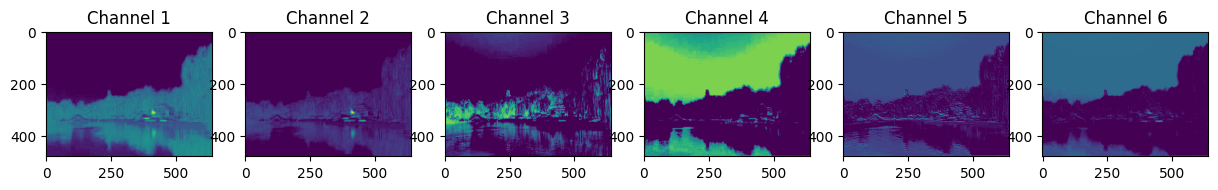

r_concat1:[[[[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   ...
   [0.04889906 0.0476995  0.04649993 ... 0.27586915 0.29146349
    0.30106001]
   [0.04889906 0.04649993 0.04530037 ... 0.27466958 0.29026392
    0.29986044]
   [0.04889906 0.04649993 0.04530037 ... 0.27347002 0.28906436
    0.29866088]]

  [[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   ...
   [0.         0.         0.         ... 0.07703894 0.08893565
    0.09625671]
   [0.         0.         0.         ... 0.07612381 0.08802052
    0.09534157]
   [0.         0.         0.         ... 0.07520867 0.08710539
    0.09442644]]

  [[0.01900888 0.01900888 0.01900888 ... 0.         0.
    0.        ]
 

In [ ]:
r_concat1 = concat(r_relu1,r_relu2)
visualize_channels_int8(r_concat1*255.0)
print(f"r_concat1:{r_concat1}")
print(f"r_concat1.shape:{r_concat1.shape}")

In [ ]:
r_conv3 = conv2d(r_concat1, w_conv3, b_conv3, conv3_shape, stride=1, padding='SAME')
print(f"r_conv3:{r_conv3}")
print(f"r_conv3.shape:{r_conv3.shape}")
print(f"r_conv3.dtype:{r_conv3.dtype}")

r_conv3:[[[[ 7.09169565e-02 -8.86031815e-02 -1.17814903e-01 ... -1.33966939e-01
    -1.57628660e-01 -1.03386887e-01]
   [ 6.88296947e-02 -1.03719715e-01 -1.35782554e-01 ... -1.56660982e-01
    -1.86653319e-01 -1.11133259e-01]
   [ 1.41877296e-01 -6.92220259e-02 -1.00460800e-01 ... -1.21982080e-01
    -1.73040648e-01 -9.55730842e-02]
   ...
   [ 6.90436947e-02 -1.38209237e-01 -1.40205907e-01 ... -1.43281865e-01
    -7.75325810e-02 -3.55379946e-02]
   [ 2.36615975e-01  7.45487658e-02  1.00861955e-01 ...  9.59557461e-02
     5.12626083e-02  5.36889146e-02]
   [ 8.42823459e-02 -3.23095909e-02 -6.83620397e-02 ... -1.38552605e-01
    -1.20234300e-01 -5.57619288e-02]]

  [[ 2.21914492e-01  2.69051788e-01  2.62255609e-01 ...  2.67060736e-01
     2.15459129e-01  2.84079611e-01]
   [ 2.22590869e-01  2.90226219e-01  2.72483306e-01 ...  3.02265399e-01
     2.47117635e-01  3.48287889e-01]
   [ 1.51372710e-01  2.18532175e-01  1.67704088e-01 ...  1.89535503e-01
     1.67274978e-01  3.44257401e-01]
  

In [ ]:
print(f"MSE(r_conv3,dq_conv3):{MSE(r_conv3,dq_conv3)}")

MSE(r_conv3,dq_conv3):0.07693476597860732


In [ ]:
r_relu3 = Relu(r_conv3)
print(f"r_relu3:{r_relu3}")
print(f"r_relu3.shape:{r_relu3.shape}")

r_relu3:[[[[0.07091696 0.         0.         ... 0.         0.
    0.        ]
   [0.06882969 0.         0.         ... 0.         0.
    0.        ]
   [0.1418773  0.         0.         ... 0.         0.
    0.        ]
   ...
   [0.06904369 0.         0.         ... 0.         0.
    0.        ]
   [0.23661598 0.07454877 0.10086195 ... 0.09595575 0.05126261
    0.05368891]
   [0.08428235 0.         0.         ... 0.         0.
    0.        ]]

  [[0.22191449 0.26905179 0.26225561 ... 0.26706074 0.21545913
    0.28407961]
   [0.22259087 0.29022622 0.27248331 ... 0.3022654  0.24711764
    0.34828789]
   [0.15137271 0.21853218 0.16770409 ... 0.1895355  0.16727498
    0.3442574 ]
   ...
   [0.1728406  0.15986738 0.10142844 ... 0.01062081 0.03455605
    0.0978776 ]
   [0.16630951 0.1523927  0.10869318 ... 0.03611145 0.01974295
    0.09847842]
   [0.23730514 0.26575117 0.25242638 ... 0.12823065 0.09842885
    0.1981782 ]]

  [[0.         0.         0.         ... 0.24872981 0.29963559
   

In [ ]:
print(f"MSE(r_relu3,dq_conv3):{MSE(r_relu3,dqrelu3)}")

MSE(r_relu3,dq_conv3):0.0023988204125627716


concat2的计算

In [ ]:
q_concat2_fp = quantization_int8(dqrelu3,Sconcat2,Zconcat2)
q_concat2_int = requantize(qrelu3,Sy3,Zy3,Sconcat2,Zconcat2)
print(f"MSE(q_concat2_fp,q_concat2_int):{MSE(q_concat2_fp,q_concat2_int)}")
print(f"q_concat2_fp:{q_concat2_fp}")
print(f"q_concat2_int:{q_concat2_int}")

M:[249]
MSE(q_concat2_fp,q_concat2_int):0.03075737847222222
q_concat2_fp:[[[[-128 -128 -128 ... -128   60  -91]
   [-128 -128  -94 ... -124  120  -68]
   [-128 -128 -128 ... -128  -20 -128]
   ...
   [-128 -128 -104 ... -123  120  -24]
   [-128 -128 -128 ... -128 -128 -128]
   [-128 -128 -128 ... -128 -128 -128]]

  [[-128 -128 -128 ... -128 -128 -128]
   [-128 -128 -128 ... -128  -95 -128]
   [-109 -128  -49 ... -104   67 -128]
   ...
   [ -53 -128  -62 ... -128  -56 -128]
   [ -87 -128 -120 ... -128  -96 -128]
   [-128 -128 -128 ... -128 -128 -128]]

  [[-128 -128 -128 ... -128 -128 -128]
   [-128 -128 -128 ... -128 -128 -128]
   [-128 -128 -128 ...   20 -128 -128]
   ...
   [-128 -128 -128 ... -128 -128 -128]
   [-128 -128 -128 ... -128 -128 -128]
   [-128 -128 -128 ... -128 -128 -128]]]]
q_concat2_int:[[[[-128 -128 -128 ... -128   60  -91]
   [-128 -128  -94 ... -124  120  -68]
   [-128 -128 -128 ... -128  -20 -128]
   ...
   [-128 -128 -104 ... -123  120  -24]
   [-128 -128 -128 .

In [ ]:
q_concat2 = concat(qrelu2,q_concat2_int)
print(f"q_concat2:{q_concat2}")
print(f"q_concat2.shape:{q_concat2.shape}")
print(f"q_concat2.dtype:{q_concat2.dtype}")

q_concat2:[[[[-128 -128 -128 ... -128 -128 -128]
   [-128  -96  -96 ...  -90  -90 -128]
   [-128  -96  -96 ...  -90  -90 -128]
   ...
   [-128 -113 -112 ... -128 -128 -128]
   [-128 -112 -111 ... -128 -128 -128]
   [-128 -128 -128 ... -128 -128 -128]]

  [[ -27   69   69 ...   74   74  127]
   [-101  -98  -98 ... -100 -100   25]
   [-101  -98  -98 ... -100 -100   25]
   ...
   [ -97  -97  -97 ... -128 -128  -92]
   [ -99 -100 -101 ... -128 -128  -87]
   [-128 -128 -128 ... -128 -128 -128]]

  [[-108   14   14 ...   15   15   14]
   [-128  -73  -73 ...  -74  -74  -58]
   [-128  -73  -73 ...  -74  -74  -58]
   ...
   [-128  -97  -96 ... -128 -128 -128]
   [-128  -97  -96 ... -128 -128 -128]
   [-128 -128 -128 ... -128 -128 -128]]

  [[-128 -128 -128 ... -128   60  -91]
   [-128 -128  -94 ... -124  120  -68]
   [-128 -128 -128 ... -128  -20 -128]
   ...
   [-128 -128 -104 ... -123  120  -24]
   [-128 -128 -128 ... -128 -128 -128]
   [-128 -128 -128 ... -128 -128 -128]]

  [[-128 -128 -128

conv+relu4计算

In [ ]:
print(f"q_concat2.dtype:{q_concat2.dtype}")
print(f"qw4.dtype:{qw4.dtype}")

q_concat2.dtype:int8
qw4.dtype:int8


M:[[401 124 234]]
B:[[-277  -35 -659]]
q_conv4:[[[[-350  -96 -154 ...  -89  -65 -346]
   [-301   39  -28 ...   -3   15 -333]
   [-470 -102 -240 ... -225 -128 -521]
   ...
   [-389  -43 -172 ... -111 -150 -477]
   [-351  -43 -149 ... -118 -138 -423]
   [-436 -198 -308 ... -292 -282 -478]]

  [[ -26  -28  -14 ...  -98   -6   15]
   [ -62  -82  -74 ... -176  -37  -29]
   [ -51  -63  -35 ... -154    9    9]
   ...
   [ -91  -98  -66 ... -176  -31  -16]
   [ -61  -61  -33 ... -129  -29  -18]
   [ -53  -54  -46 ... -117  -59  -42]]

  [[-529 -487 -507 ... -549 -497 -672]
   [-396 -328 -341 ... -387 -360 -585]
   [-288 -203 -214 ... -295 -271 -535]
   ...
   [-275 -172 -206 ... -191 -243 -514]
   [-341 -249 -296 ... -265 -327 -555]
   [-397 -314 -364 ... -325 -369 -561]]]]
q_conv4.shape:(1, 3, 480, 640)
q_conv4.dtype:int32


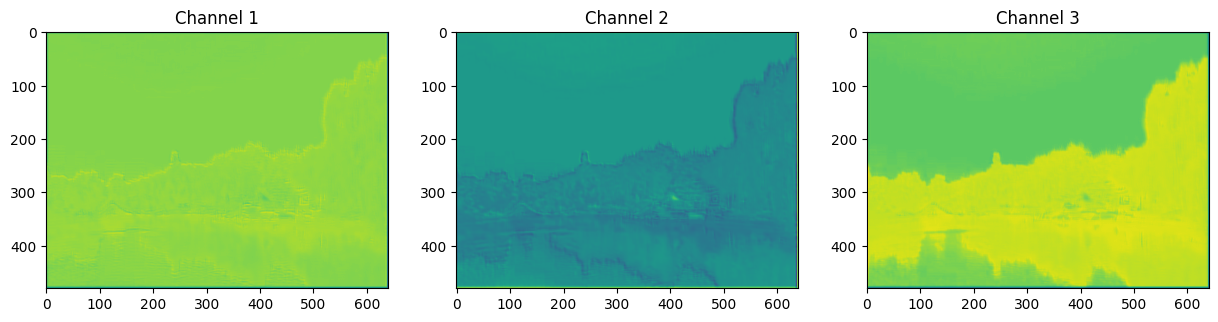

deahze_img.shape:(1, 3, 480, 640)
deahze_img.shape after:(3, 480, 640)


In [ ]:
q_conv4 = Q_conv2d_fused(q_concat2,qw4,qb4,Sx4,Zx4,Sw4,Sb4,Sy4,Zy4,conv4_shape,stride=1,padding='SAME')
print(f"q_conv4:{q_conv4}")
print(f"q_conv4.shape:{q_conv4.shape}")
print(f"q_conv4.dtype:{q_conv4.dtype}")
visualize_channels_int8(q_conv4)
array_show(q_conv4)

In [ ]:
dq_conv4 = dequantization(q_conv4,Sy4,Zy4)
print(f"dq_conv4:{dq_conv4}")
print(f"dq_conv4.shape:{dq_conv4.shape}")
print(f"dq_conv4.dtype:{dq_conv4.dtype}")

dq_conv4:[[[[-1.022912    0.14744678 -0.11980051 ...  0.17970076  0.29028586
    -1.0044812 ]
   [-0.79713416  0.7694879   0.4607712  ...  0.575964    0.6589028
    -0.944581  ]
   [-1.5758375   0.11980051 -0.51606375 ... -0.44694805  0.
    -1.8108308 ]
   ...
   [-1.2026128   0.3916555  -0.20273933 ...  0.07833111 -0.10136966
    -1.6080915 ]
   [-1.0275197   0.3916555  -0.09676195 ...  0.04607712 -0.04607712
    -1.359275  ]
   [-1.4191753  -0.32253984 -0.82938814 ... -0.75566477 -0.70958763
    -1.6126992 ]]

  [[ 0.46998662  0.4607712   0.52527916 ...  0.13823135  0.5621409
     0.6589028 ]
   [ 0.30410898  0.21195474  0.24881645 ... -0.22117017  0.41930178
     0.45616347]
   [ 0.35479382  0.29950127  0.42851722 ... -0.11980051  0.6312565
     0.6312565 ]
   ...
   [ 0.17048535  0.13823135  0.28567815 ... -0.22117017  0.44694805
     0.51606375]
   [ 0.30871668  0.30871668  0.43773264 ... -0.00460771  0.45616347
     0.50684834]
   [ 0.3455784   0.3409707   0.37783238 ...  0.0506

relu4的计算

deahze_img.shape:(1, 3, 480, 640)
deahze_img.shape after:(3, 480, 640)



(eog:13886): EOG-WARNING **: 16:34:34.129: Couldn't load icon: Icon 'image-loading' not present in theme Adwaita

(eog:13886): EOG-WARNING **: 16:34:34.326: Couldn't load icon: Icon 'image-loading' not present in theme Adwaita


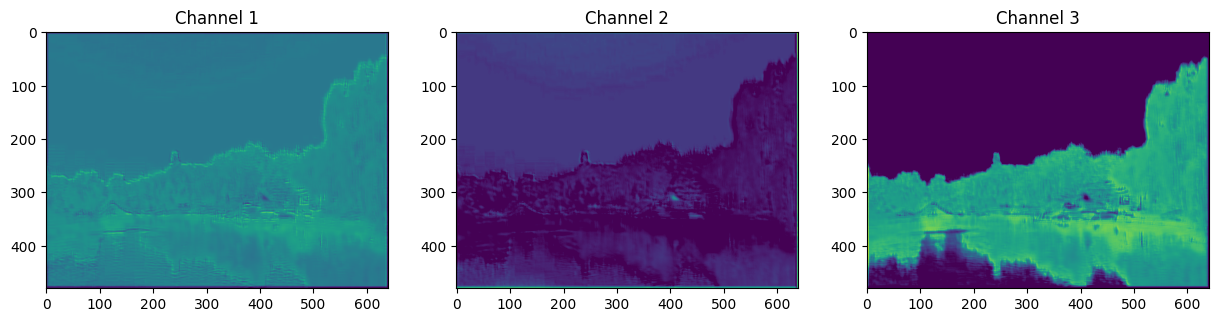

qrelu4:[[[[-128  -96 -128 ...  -89  -65 -128]
   [-128   39  -28 ...   -3   15 -128]
   [-128 -102 -128 ... -128 -128 -128]
   ...
   [-128  -43 -128 ... -111 -128 -128]
   [-128  -43 -128 ... -118 -128 -128]
   [-128 -128 -128 ... -128 -128 -128]]

  [[ -26  -28  -14 ...  -98   -6   15]
   [ -62  -82  -74 ... -128  -37  -29]
   [ -51  -63  -35 ... -128    9    9]
   ...
   [ -91  -98  -66 ... -128  -31  -16]
   [ -61  -61  -33 ... -128  -29  -18]
   [ -53  -54  -46 ... -117  -59  -42]]

  [[-128 -128 -128 ... -128 -128 -128]
   [-128 -128 -128 ... -128 -128 -128]
   [-128 -128 -128 ... -128 -128 -128]
   ...
   [-128 -128 -128 ... -128 -128 -128]
   [-128 -128 -128 ... -128 -128 -128]
   [-128 -128 -128 ... -128 -128 -128]]]]
qrelu4.shape:(1, 3, 480, 640)
qrelu4.dtype:int8


In [ ]:
qrelu4 = Q_Relu(Zy4,Sy4,Zy4,Sy4,q_conv4)
array_show(qrelu4)
visualize_channels_int8(qrelu4)
print(f"qrelu4:{qrelu4}")
print(f"qrelu4.shape:{qrelu4.shape}")
print(f"qrelu4.dtype:{qrelu4.dtype}")

In [ ]:
dqrelu4 = dequantization(qrelu4,Sy4,Zy4)
print(f"dqrelu4:{dqrelu4}")
print(f"dqrelu4.dtype:{dqrelu4.dtype}")
print(f"dqrelu4.shape:{dqrelu4.shape}")

dqrelu4:[[[[0.         0.14744678 0.         ... 0.17970076 0.29028586
    0.        ]
   [0.         0.7694879  0.4607712  ... 0.575964   0.6589028
    0.        ]
   [0.         0.11980051 0.         ... 0.         0.
    0.        ]
   ...
   [0.         0.3916555  0.         ... 0.07833111 0.
    0.        ]
   [0.         0.3916555  0.         ... 0.04607712 0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]]

  [[0.46998662 0.4607712  0.52527916 ... 0.13823135 0.5621409
    0.6589028 ]
   [0.30410898 0.21195474 0.24881645 ... 0.         0.41930178
    0.45616347]
   [0.35479382 0.29950127 0.42851722 ... 0.         0.6312565
    0.6312565 ]
   ...
   [0.17048535 0.13823135 0.28567815 ... 0.         0.44694805
    0.51606375]
   [0.30871668 0.30871668 0.43773264 ... 0.         0.45616347
    0.50684834]
   [0.3455784  0.3409707  0.37783238 ... 0.05068483 0.31793213
    0.3962632 ]]

  [[0.         0.         0.         ... 0.         0.
    0.

FP32卷积计算

In [ ]:
r_concat2 = concat(r_relu2,r_relu3)
print(f"r_concat2:{r_concat2}")
print(f"r_concat2.shape:{r_concat2.shape}")
r_conv4 = conv2d(r_concat2, w_conv4, b_conv4, conv4_shape, stride=1, padding='SAME')
print(f"r_conv4:{r_conv4}")
print(f"r_conv4.shape:{r_conv4.shape}")
print(f"r_conv4.dtype:{r_conv4.dtype}")

r_concat2:[[[[0.06846791 0.06627964 0.06627964 ... 0.06817713 0.06817713
    0.06817713]
   [0.066356   0.05914777 0.05914777 ... 0.06817713 0.06817713
    0.06817713]
   [0.066356   0.05914777 0.05914777 ... 0.06817713 0.06817713
    0.06817713]
   ...
   [0.05318676 0.02633312 0.02913329 ... 0.         0.
    0.        ]
   [0.0529292  0.02780209 0.0302085  ... 0.         0.
    0.        ]
   [0.07017638 0.05851484 0.05913252 ... 0.03057572 0.03529203
    0.        ]]

  [[0.04415065 0.04158979 0.04158979 ... 0.05108311 0.05108311
    0.05108311]
   [0.05367124 0.0551015  0.0551015  ... 0.05108311 0.05108311
    0.05108311]
   [0.05367124 0.0551015  0.0551015  ... 0.05108311 0.05108311
    0.05108311]
   ...
   [0.06206205 0.05648201 0.05533755 ... 0.         0.
    0.        ]
   [0.05786981 0.05102185 0.0497725  ... 0.         0.
    0.        ]
   [0.08548763 0.10571794 0.10050311 ... 0.16871814 0.18418588
    0.12048501]]

  [[0.10145488 0.09480878 0.09480878 ... 0.09773736 0.09

In [ ]:
print(f"MSE(r_conv4,dq_conv4):{MSE(r_conv4,dq_conv4)}")

MSE(r_conv4,dq_conv4):0.029102029425159163


In [ ]:
r_relu4 = Relu(r_conv4)
print(f"r_relu4:{r_relu4}")
print(f"r_relu4.shape:{r_relu4.shape}")

r_relu4:[[[[0.46245687 0.23820534 0.36595095 ... 0.22072554 0.20706648
    0.62444826]
   [0.38803721 0.05745745 0.14891412 ... 0.16135599 0.10669877
    0.62564111]
   [0.58545954 0.22971811 0.43968592 ... 0.39382849 0.28968965
    0.84641301]
   ...
   [0.74884021 0.1771011  0.46491575 ... 0.39733117 0.38126889
    0.39825934]
   [0.57364426 0.04275693 0.3132003  ... 0.23136742 0.25094663
    0.30686466]
   [0.72159127 0.32788665 0.56049416 ... 0.43945602 0.41069615
    0.42253322]]

  [[0.03804194 0.         0.         ... 0.         0.
    0.02721562]
   [0.05670594 0.03197961 0.01253459 ... 0.         0.
    0.0642868 ]
   [0.0739003  0.04529886 0.01343735 ... 0.         0.
    0.07115126]
   ...
   [0.04111974 0.02567332 0.         ... 0.05228246 0.
    0.11125048]
   [0.01044929 0.         0.         ... 0.00973962 0.
    0.07110543]
   [0.06112096 0.03913369 0.04404141 ... 0.05039565 0.02956137
    0.10181464]]

  [[0.28610477 0.31939464 0.34722982 ... 0.29463963 0.29729719
   

In [ ]:
rq_concat2 = dequantization(q_concat2,Sconcat2,Zconcat2)
print(f"MSE(r_concat2,rq_concat2):{MSE(r_concat2,rq_concat2)}")
print(f"MSE(r_relu4,dq_conv4):{MSE(r_relu4,dqrelu4)}")

MSE(r_concat2,rq_concat2):0.0018809765769273272
MSE(r_relu4,dq_conv4):0.01832474646553995


Concat3计算

In [ ]:
q_concat3_1 = quantization_int8(dqrelu4,Sconcat3,Zconcat3)
q_concat3 = requantize(qrelu4,Sy4,Zy4,Sconcat3,Zconcat3)
print(f"MSE(q_concat3_1,q_concat3_1):{MSE(q_concat3_1,q_concat3_1)}")

print(f"q_concat3_1:{q_concat3_1}")
print(f"q_concat3:{q_concat3}")

M:[666]
MSE(q_concat3_1,q_concat3_1):0.0
q_concat3_1:[[[[-128  -45 -128 ...  -27   36 -128]
   [-128  127  127 ...  127  127 -128]
   [-128  -60 -128 ... -128 -128 -128]
   ...
   [-128   93 -128 ...  -84 -128 -128]
   [-128   93 -128 ... -102 -128 -128]
   [-128 -128 -128 ... -128 -128 -128]]

  [[ 127  127  127 ...  -50  127  127]
   [  44   -8   12 ... -128  109  127]
   [  72   41  114 ... -128  127  127]
   ...
   [ -32  -50   33 ... -128  124  127]
   [  46   46  119 ... -128  127  127]
   [  67   64   85 ...  -99   51   96]]

  [[-128 -128 -128 ... -128 -128 -128]
   [-128 -128 -128 ... -128 -128 -128]
   [-128 -128 -128 ... -128 -128 -128]
   ...
   [-128 -128 -128 ... -128 -128 -128]
   [-128 -128 -128 ... -128 -128 -128]
   [-128 -128 -128 ... -128 -128 -128]]]]
q_concat3:[[[[-128  -45 -128 ...  -27   36 -128]
   [-128  127  127 ...  127  127 -128]
   [-128  -60 -128 ... -128 -128 -128]
   ...
   [-128   93 -128 ...  -84 -128 -128]
   [-128   93 -128 ... -102 -128 -128]
   [-

In [ ]:
q_concat3 = concat(qrelu3,q_concat3)
print(f"q_concat3:{q_concat3}")
print(f"q_concat3.shape:{q_concat3.shape}")
print(f"q_concat3.dtype:{q_concat3.dtype}")

q_concat3:[[[[-128 -128 -128 ... -128   65  -90]
   [-128 -128  -93 ... -124  127  -66]
   [-128 -128 -128 ... -128  -17 -128]
   ...
   [-128 -128 -103 ... -123  127  -21]
   [-128 -128 -128 ... -128 -128 -128]
   [-128 -128 -128 ... -128 -128 -128]]

  [[-128 -128 -128 ... -128 -128 -128]
   [-128 -128 -128 ... -128  -94 -128]
   [-108 -128  -47 ... -103   72 -128]
   ...
   [ -51 -128  -60 ... -128  -54 -128]
   [ -86 -128 -120 ... -128  -95 -128]
   [-128 -128 -128 ... -128 -128 -128]]

  [[-128 -128 -128 ... -128 -128 -128]
   [-128 -128 -128 ... -128 -128 -128]
   [-128 -128 -128 ...   24 -128 -128]
   ...
   [-128 -128 -128 ... -128 -128 -128]
   [-128 -128 -128 ... -128 -128 -128]
   [-128 -128 -128 ... -128 -128 -128]]

  [[-128  -45 -128 ...  -27   36 -128]
   [-128  127  127 ...  127  127 -128]
   [-128  -60 -128 ... -128 -128 -128]
   ...
   [-128   93 -128 ...  -84 -128 -128]
   [-128   93 -128 ... -102 -128 -128]
   [-128 -128 -128 ... -128 -128 -128]]

  [[ 127  127  127

conv+relu5计算

In [ ]:
print(f"q_concat3.dtype:{q_concat3.dtype}")
print(f"qw5.dtype:{qw5.dtype}")

q_concat3.dtype:int8
qw5.dtype:int8


M:[[62 69 65]]
B:[[166 168 161]]
q_conv5:[[[[ 87  76  66 ...  75  88 126]
   [ 57  54  60 ...  83  58 136]
   [ 58  38  30 ...  77  37 145]
   ...
   [ 45  40  26 ...  28   3 123]
   [ 54  42  32 ...  -6 -16 108]
   [ 93  59  66 ...  21  33 109]]

  [[111  81  79 ...  86  77 140]
   [ 76  59  55 ...  82  49 129]
   [ 64  29  35 ...  48  50 156]
   ...
   [ 63  27  17 ...  19  17 113]
   [ 71  44  33 ... -17  -3  98]
   [ 81  61  61 ...  10  36 117]]

  [[ 93  81  78 ...  81  68 113]
   [ 62  43  50 ...  67  54 117]
   [ 54  27  15 ...  21  63 112]
   ...
   [ 66  12  18 ... -10  33  93]
   [ 64  22  39 ... -23   3  78]
   [ 82  63  61 ...  23  30 107]]]]
q_conv5.shape:(1, 3, 480, 640)
q_conv5.dtype:int32
deahze_img.shape:(1, 3, 480, 640)
deahze_img.shape after:(3, 480, 640)



(eog:13886): EOG-WARNING **: 16:34:35.584: Couldn't load icon: Icon 'image-loading' not present in theme Adwaita


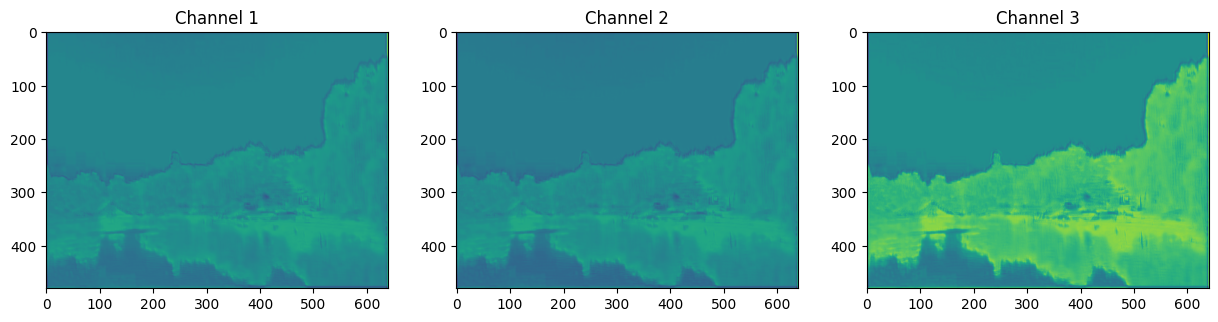

In [ ]:
q_conv5 = Q_conv2d_fused(q_concat3,qw5,qb5,Sx5,Zx5,Sw5,Sb5,Sy5,Zy5,conv5_shape,stride=1,padding='SAME')
print(f"q_conv5:{q_conv5}")
print(f"q_conv5.shape:{q_conv5.shape}")
print(f"q_conv5.dtype:{q_conv5.dtype}")
array_show(q_conv5)
visualize_channels_int8(q_conv5)

In [ ]:
dq_conv5 = dequantization(q_conv5,Sy5,Zy5)
print(f"dq_conv5:{dq_conv5}")
print(f"dq_conv5.shape:{dq_conv5.shape}")
print(f"dq_conv5.dtype:{dq_conv5.dtype}")

dq_conv5:[[[[1.415461   1.343042   1.2772067  ... 1.3364584  1.4220445
    1.672219  ]
   [1.2179548  1.1982042  1.2377053  ... 1.3891268  1.2245383
    1.7380544 ]
   [1.2245383  1.0928675  1.0401992  ... 1.3496256  1.086284
    1.7973062 ]
   ...
   [1.1389523  1.1060346  1.013865   ... 1.0270321  0.8624436
    1.6524683 ]
   [1.1982042  1.1192017  1.0533663  ... 0.8031918  0.7373564
    1.5537152 ]
   [1.4549621  1.2311219  1.2772067  ... 0.9809474  1.0599499
    1.5602988 ]]

  [[1.573466   1.3759598  1.3627926  ... 1.4088774  1.3496256
    1.7643886 ]
   [1.343042   1.2311219  1.2047877  ... 1.3825432  1.1652864
    1.6919696 ]
   [1.2640395  1.0336157  1.0731169  ... 1.158703   1.17187
    1.8697251 ]
   ...
   [1.2574561  1.0204486  0.9546132  ... 0.9677803  0.9546132
    1.586633  ]
   [1.3101243  1.1323688  1.0599499  ... 0.73077285 0.82294244
    1.4878799 ]
   [1.3759598  1.2442889  1.2442889  ... 0.90852845 1.0797005
    1.6129671 ]]

  [[1.4549621  1.3759598  1.356209   ..

relu5的计算

deahze_img.shape:(1, 3, 480, 640)
deahze_img.shape after:(3, 480, 640)



(eog:13886): EOG-WARNING **: 16:34:36.223: Couldn't load icon: Icon 'image-loading' not present in theme Adwaita


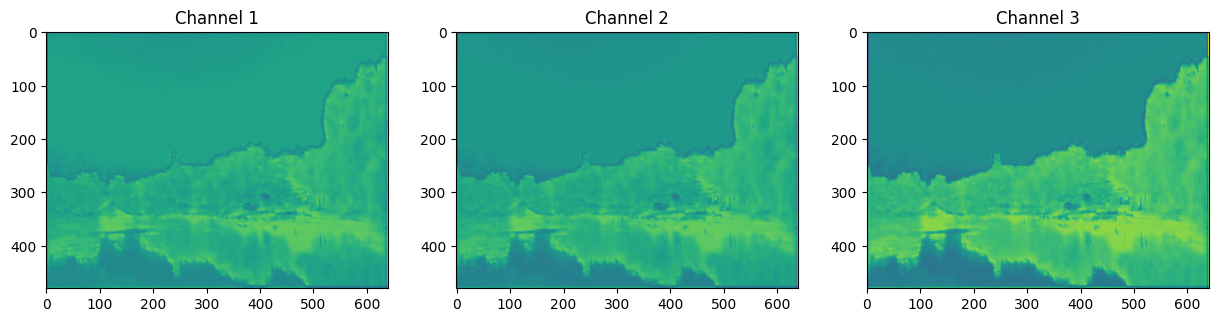

qrelu5:[[[[ 87  76  66 ...  75  88 126]
   [ 57  54  60 ...  83  58 127]
   [ 58  38  30 ...  77  37 127]
   ...
   [ 45  40  26 ...  28   3 123]
   [ 54  42  32 ...  -6 -16 108]
   [ 93  59  66 ...  21  33 109]]

  [[111  81  79 ...  86  77 127]
   [ 76  59  55 ...  82  49 127]
   [ 64  29  35 ...  48  50 127]
   ...
   [ 63  27  17 ...  19  17 113]
   [ 71  44  33 ... -17  -3  98]
   [ 81  61  61 ...  10  36 117]]

  [[ 93  81  78 ...  81  68 113]
   [ 62  43  50 ...  67  54 117]
   [ 54  27  15 ...  21  63 112]
   ...
   [ 66  12  18 ... -10  33  93]
   [ 64  22  39 ... -23   3  78]
   [ 82  63  61 ...  23  30 107]]]]
qrelu5.shape:(1, 3, 480, 640)
qrelu5.dtype:int8


In [ ]:
qrelu5 = Q_Relu(Zy4,Sy4,Zy4,Sy4,q_conv5)
array_show(qrelu5)
visualize_channels_int8(qrelu5)
print(f"qrelu5:{qrelu5}")
print(f"qrelu5.shape:{qrelu5.shape}")
print(f"qrelu5.dtype:{qrelu5.dtype}")

In [ ]:
dqrelu5 = dequantization(qrelu5,Sy5,Zy5)
print(f"dqrelu5:{dqrelu5}")
print(f"dqrelu5.dtype:{dqrelu5.dtype}")
print(f"dqrelu5.shape:{dqrelu5.shape}")

dqrelu5:[[[[1.415461   1.343042   1.2772067  ... 1.3364584  1.4220445
    1.672219  ]
   [1.2179548  1.1982042  1.2377053  ... 1.3891268  1.2245383
    1.6788025 ]
   [1.2245383  1.0928675  1.0401992  ... 1.3496256  1.086284
    1.6788025 ]
   ...
   [1.1389523  1.1060346  1.013865   ... 1.0270321  0.8624436
    1.6524683 ]
   [1.1982042  1.1192017  1.0533663  ... 0.8031918  0.7373564
    1.5537152 ]
   [1.4549621  1.2311219  1.2772067  ... 0.9809474  1.0599499
    1.5602988 ]]

  [[1.573466   1.3759598  1.3627926  ... 1.4088774  1.3496256
    1.6788025 ]
   [1.343042   1.2311219  1.2047877  ... 1.3825432  1.1652864
    1.6788025 ]
   [1.2640395  1.0336157  1.0731169  ... 1.158703   1.17187
    1.6788025 ]
   ...
   [1.2574561  1.0204486  0.9546132  ... 0.9677803  0.9546132
    1.586633  ]
   [1.3101243  1.1323688  1.0599499  ... 0.73077285 0.82294244
    1.4878799 ]
   [1.3759598  1.2442889  1.2442889  ... 0.90852845 1.0797005
    1.6129671 ]]

  [[1.4549621  1.3759598  1.356209   ...

FP32计算结果

In [ ]:
r_concat3 = concat(r_relu3,r_relu4)
print(f"r_concat3:{r_concat3}")
print(f"r_concat3.shape:{r_concat3.shape}")
r_conv5 = conv2d(r_concat3, w_conv5, b_conv5, conv5_shape, stride=1, padding='SAME')
print(f"r_conv5:{r_conv5}")
print(f"r_conv5.shape:{r_conv5.shape}")
print(f"r_conv5.dtype:{r_conv5.dtype}")

r_concat3:[[[[0.07091696 0.         0.         ... 0.         0.
    0.        ]
   [0.06882969 0.         0.         ... 0.         0.
    0.        ]
   [0.1418773  0.         0.         ... 0.         0.
    0.        ]
   ...
   [0.06904369 0.         0.         ... 0.         0.
    0.        ]
   [0.23661598 0.07454877 0.10086195 ... 0.09595575 0.05126261
    0.05368891]
   [0.08428235 0.         0.         ... 0.         0.
    0.        ]]

  [[0.22191449 0.26905179 0.26225561 ... 0.26706074 0.21545913
    0.28407961]
   [0.22259087 0.29022622 0.27248331 ... 0.3022654  0.24711764
    0.34828789]
   [0.15137271 0.21853218 0.16770409 ... 0.1895355  0.16727498
    0.3442574 ]
   ...
   [0.1728406  0.15986738 0.10142844 ... 0.01062081 0.03455605
    0.0978776 ]
   [0.16630951 0.1523927  0.10869318 ... 0.03611145 0.01974295
    0.09847842]
   [0.23730514 0.26575117 0.25242638 ... 0.12823065 0.09842885
    0.1981782 ]]

  [[0.         0.         0.         ... 0.24872981 0.29963559
 

In [ ]:
print(f"MSE(r_conv5,dq_conv5):{MSE(r_conv5,dq_conv5)}")

MSE(r_conv5,dq_conv5):0.018456828634206994


In [ ]:
r_relu5 = Relu(r_conv5)
print(f"r_relu5:{r_relu5}")
print(f"r_relu5.shape:{r_relu5.shape}")

r_relu5:[[[[1.01057419 1.12783441 1.22114981 ... 1.2193752  1.3050307
    1.13787698]
   [1.12206016 1.24074216 1.25079772 ... 1.32447931 1.33485973
    1.37786255]
   [1.18536119 1.2125131  1.24420664 ... 1.29991581 1.33696385
    1.36323441]
   ...
   [1.23404387 1.2199228  1.23584031 ... 1.23181229 1.25422076
    1.17823032]
   [1.23327788 1.24907939 1.26633446 ... 1.23447229 1.24961172
    1.14182   ]
   [1.07764852 1.16684481 1.18365867 ... 1.11087163 1.10182042
    1.07551354]]

  [[0.9301505  1.13200652 1.18004688 ... 1.19579478 1.1812623
    1.18081397]
   [1.02991401 1.20712778 1.20557092 ... 1.31807184 1.2835302
    1.42558102]
   [1.11134261 1.21416899 1.20894306 ... 1.27083525 1.25124948
    1.44793204]
   ...
   [1.21258934 1.19984144 1.2020943  ... 1.24405563 1.20990556
    1.1537616 ]
   [1.1504889  1.19752772 1.23525201 ... 1.24728504 1.21700898
    1.16756355]
   [1.13970288 1.09541651 1.19178612 ... 1.1062866  1.07517255
    0.99643164]]

  [[0.86259189 1.08069172 1.1

In [ ]:
print(f"MSE(r_relu5,dq_conv5):{MSE(r_relu5,dqrelu5)}")

MSE(r_relu5,dq_conv5):0.018424718148855244


mul计算

M:[280]
deahze_img.shape:(1, 3, 480, 640)
deahze_img.shape after:(3, 480, 640)



(eog:13886): EOG-WARNING **: 16:34:37.021: Couldn't load icon: Icon 'image-loading' not present in theme Adwaita


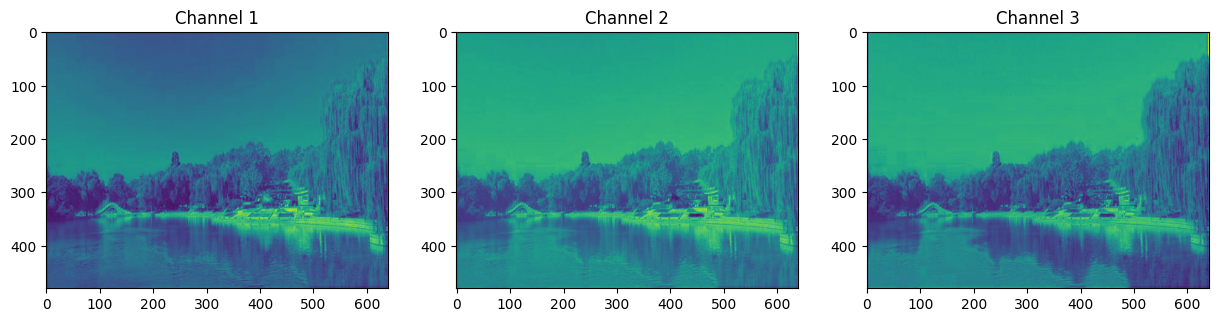

q_mul:[[[[  2  -5 -11 ...   6  14  39]
   [-17 -18 -15 ...  11  -6  40]
   [-16 -28 -33 ...   7 -19  40]
   ...
   [-35 -37 -44 ... -43 -64 -13]
   [-30 -35 -40 ... -61 -72 -19]
   [ -9 -26 -21 ... -45 -48 -18]]

  [[ 61  37  36 ...  47  39  80]
   [ 33  20  17 ...  43  16  80]
   [ 24  -4   1 ...  16  17  80]
   ...
   [  2 -22 -28 ... -44 -54 -13]
   [  7 -10 -17 ... -64 -63 -19]
   [ 14   2   3 ... -48 -43  -9]]

  [[ 72  61  59 ...  67  55  96]
   [ 44  27  33 ...  54  42 100]
   [ 37  12   2 ...  11  50  96]
   ...
   [ 16 -23 -18 ... -76 -66 -51]
   [ 15 -15  -2 ... -81 -77 -55]
   [ 28  16  15 ... -60 -66 -44]]]]
q_mul.dtype:int8


In [ ]:
q_mul = q_mul_fun(qrelu5,Sy5,Zy5,haze_img_int8,Sx1,Zx1,Smul_out,Zmul_out)
array_show(q_mul)
visualize_channels_int8(q_mul)
print(f"q_mul:{q_mul}")
print(f"q_mul.dtype:{q_mul.dtype}")

解量化+mul+量化计算

In [ ]:
print(f"dqrelu5.dtype:{dqrelu5.dtype}")
print(f"hazy_image_quant.dtype:{hazy_image.dtype}")

dqrelu5.dtype:float32
hazy_image_quant.dtype:float64


In [ ]:
dq_mul_quant = dqrelu5*hazy_image
print(f"dq_mul_quant:{dq_mul_quant}")
print(f"dq_mul_quant.shape:{dq_mul_quant.shape}")
print(f"dq_mul_quant.dtype:{dq_mul_quant.dtype}")

dq_mul_quant:[[[[0.78266664 0.74262323 0.70622015 ... 0.80711608 0.85880335
    1.00988914]
   [0.67345734 0.66253642 0.68437825 ... 0.83892362 0.73952511
    1.01386503]
   [0.67709766 0.60429144 0.57516895 ... 0.815068   0.65603036
    1.01386503]
   ...
   [0.56277641 0.55084862 0.50892047 ... 0.51552986 0.38894516
    0.69338867]
   [0.59205382 0.56179534 0.53287942 ... 0.40632055 0.33542488
    0.6580441 ]
   [0.71892247 0.61797491 0.64611631 ... 0.50009082 0.48632994
    0.66695125]]

  [[1.14153412 0.99824531 0.98869268 ... 1.05527678 1.01089603
    1.25745598]
   [0.97436382 0.89316687 0.87406169 ... 1.03555197 0.87282238
    1.25745598]
   [0.91704828 0.74987806 0.77853579 ... 0.86789124 0.8777536
    1.25745598]
   ...
   [0.78406084 0.64028145 0.60271657 ... 0.50476384 0.44922975
    0.69687409]
   [0.81690102 0.71494658 0.67337992 ... 0.38401397 0.39049425
    0.659335  ]
   [0.85795138 0.78560987 0.79048943 ... 0.48098565 0.51656258
    0.72109119]]

  [[1.20961558 1.14393

In [ ]:
q_mul_quant = quantization_int8(dq_mul_quant,Smul_out,Zmul_out)
print(f"q_mul_quant:{q_mul_quant}")
print(f"q_mul_quant.shape:{q_mul_quant.shape}")
print(f"q_mul_quant.dtype:{q_mul_quant.dtype}")

q_mul_quant:[[[[  2  -5 -11 ...   6  14  39]
   [-17 -18 -15 ...  11  -6  40]
   [-16 -28 -33 ...   7 -19  40]
   ...
   [-35 -37 -44 ... -43 -64 -13]
   [-30 -35 -40 ... -61 -72 -19]
   [ -9 -26 -21 ... -45 -47 -18]]

  [[ 61  37  36 ...  47  39  80]
   [ 33  20  17 ...  43  16  80]
   [ 24  -4   1 ...  16  17  80]
   ...
   [  2 -22 -28 ... -44 -54 -13]
   [  7 -10 -17 ... -64 -63 -19]
   [ 14   2   3 ... -48 -42  -9]]

  [[ 72  61  59 ...  67  55  97]
   [ 44  27  33 ...  54  42 100]
   [ 37  12   2 ...  11  50  96]
   ...
   [ 16 -23 -18 ... -76 -66 -51]
   [ 15 -15  -2 ... -81 -77 -55]
   [ 28  16  15 ... -60 -66 -44]]]]
q_mul_quant.shape:(1, 3, 480, 640)
q_mul_quant.dtype:int8


计算两种方法的误差

In [ ]:
print(f"MSE(q_mul_quant,q_mul):{MSE(q_mul_quant,q_mul)/100}")

MSE(q_mul_quant,q_mul):0.0004012044270833334


sub计算

qx1.dtype:int8
qx2.dtype:int8
Sx1/Sy:[1.2318841]
Sx2/Sy:[1.34243776]
M1:[20183]
M2:[-21995]
B:[113]
q_sub:[[[[ -1   5  11 ...  20  12  -8]
   [ 16  18  14 ...  15  28  -8]
   [ 15  27  32 ...  18  40  -8]
   ...
   [  9  14  24 ...  22  30 -68]
   [  4  14  21 ...  46  46 -55]
   [-23   2  -1 ...  29  10 -56]]

  [[ 39  50  51 ...  55  58  41]
   [ 52  58  60 ...  56  67  41]
   [ 57  69  67 ...  68  67  41]
   ...
   [ 31  50  56 ...  33  24 -55]
   [ 26  42  48 ...  57  39 -42]
   [ 22  34  35 ...  40  12 -55]]

  [[ 77  79  81 ...  87  89  80]
   [ 84  89  87 ...  90  92  79]
   [ 86  92  95 ...  98  90  81]
   ...
   [ 44  69  67 ...  33 -13 -75]
   [ 46  65  58 ...  44  14 -59]
   [ 37  48  50 ...   8  -9 -85]]]]
deahze_img.shape:(1, 3, 480, 640)
deahze_img.shape after:(3, 480, 640)



(eog:13886): EOG-WARNING **: 16:34:37.763: Couldn't load icon: Icon 'image-loading' not present in theme Adwaita


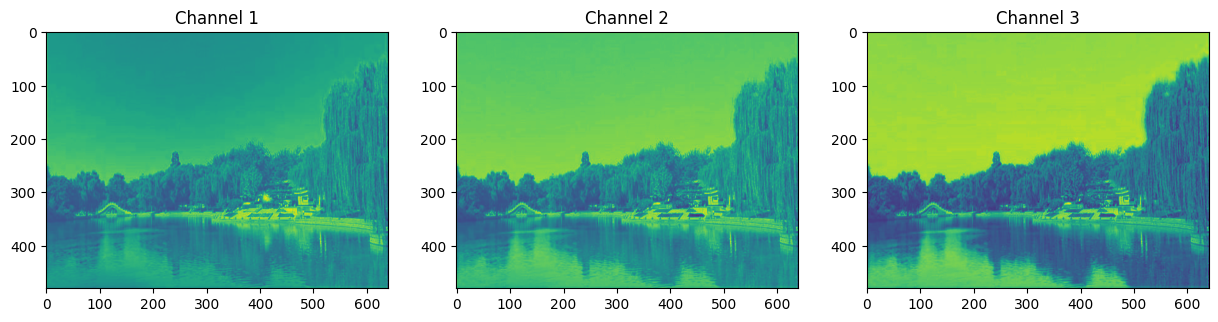

In [ ]:
q_sub = q_sub_fun(q_mul,Smul_out,Zmul_out,qrelu5,Sy5,Zy5,Ssub_out,Zsub_out)
print(f"q_sub:{q_sub}")
array_show(q_sub)
visualize_channels_int8(q_sub)

解量化+sub+量化

In [ ]:
print(f"dqrelu5.dtype:{dqrelu5.dtype}")
print(f"dq_mul_quant.dtype:{dq_mul_quant.dtype}")

dqrelu5.dtype:float32
dq_mul_quant.dtype:float64


In [ ]:
dq_sub_quant = dq_mul_quant-dqrelu5
print(f"dq_sub_quant:{dq_sub_quant}")
print(f"dq_sub_quant.shape:{dq_sub_quant.shape}")
print(f"dq_sub_quant.dtype:{dq_sub_quant.dtype}")

dq_sub_quant:[[[[-0.6327943  -0.60041878 -0.57098651 ... -0.52934236 -0.56324116
    -0.66232989]
   [-0.54449742 -0.53566774 -0.5533271  ... -0.55020316 -0.48501322
    -0.66493746]
   [-0.54744066 -0.48857606 -0.46503021 ... -0.53455759 -0.43025368
    -0.66493746]
   ...
   [-0.57617585 -0.55518601 -0.50494453 ... -0.51150228 -0.47349846
    -0.95907965]
   [-0.60615034 -0.55740632 -0.52048688 ... -0.39687123 -0.40193154
    -0.89567113]
   [-0.73603967 -0.61314698 -0.63109035 ... -0.48085656 -0.57361993
    -0.89334755]]

  [[-0.43193183 -0.37771444 -0.37409993 ... -0.3536006  -0.33872956
    -0.42134651]
   [-0.3686782  -0.33795503 -0.33072604 ... -0.34699124 -0.29246404
    -0.42134651]
   [-0.34699124 -0.28373765 -0.29458111 ... -0.29081173 -0.29411639
    -0.42134651]
   ...
   [-0.47339522 -0.38016711 -0.35189663 ... -0.46301645 -0.50538346
    -0.88975888]
   [-0.49322326 -0.41742223 -0.38656995 ... -0.34675888 -0.43244818
    -0.82854487]
   [-0.51800838 -0.45867905 -0.45379

In [ ]:
q_sub_quant = quantization_int8(dq_sub_quant,Ssub_out,Zsub_out)
print(f"q_sub_quant:{q_sub_quant}")
print(f"q_sub_quant.shape:{q_sub_quant.shape}")
print(f"q_sub_quant.dtype:{q_sub_quant.dtype}")

q_sub_quant:[[[[ -2   5  11 ...  19  12  -8]
   [ 16  18  14 ...  15  28  -9]
   [ 15  27  32 ...  18  39  -9]
   ...
   [ 10  14  24 ...  23  30 -69]
   [  3  13  21 ...  46  45 -56]
   [-23   2  -2 ...  29  10 -55]]

  [[ 39  50  51 ...  55  58  41]
   [ 52  58  60 ...  56  67  41]
   [ 56  69  67 ...  68  67  41]
   ...
   [ 30  49  55 ...  33  24 -54]
   [ 26  42  48 ...  56  39 -42]
   [ 21  33  34 ...  40  12 -55]]

  [[ 77  80  80 ...  86  89  80]
   [ 84  88  87 ...  89  92  79]
   [ 86  92  95 ...  98  90  80]
   ...
   [ 44  68  66 ...  33 -13 -74]
   [ 45  65  58 ...  44  14 -60]
   [ 37  48  49 ...   8  -9 -85]]]]
q_sub_quant.shape:(1, 3, 480, 640)
q_sub_quant.dtype:int8


sub近似计算误差

In [ ]:
print(f"MSE(q_sub_quant,q_sub):{MSE(q_sub_quant,q_sub)/100}")

MSE(q_sub_quant,q_sub):0.0031333116319444444


add计算

M:[20488]
C:[-32]
q_add:
[[[[ -33  -26  -18 ...   -7  -17  -42]
   [ -12   -9  -14 ...  -13    3  -42]
   [ -13    2    8 ...   -9   18  -42]
   ...
   [ -21  -14   -2 ...   -4    6 -117]
   [ -27  -14   -6 ...   26   26 -101]
   [ -61  -29  -33 ...    4  -19 -102]]

  [[  17   31   32 ...   37   41   19]
   [  33   41   43 ...   38   52   19]
   [  39   54   52 ...   53   52   19]
   ...
   [   7   31   38 ...    9   -2 -101]
   [   1   21   28 ...   39   17  -85]
   [  -4   11   12 ...   18  -17 -101]]

  [[  64   67   69 ...   77   79   68]
   [  73   79   77 ...   81   83   67]
   [  76   83   87 ...   91   81   69]
   ...
   [  23   54   52 ...    9  -48 -126]
   [  26   49   41 ...   23  -14 -106]
   [  14   28   31 ...  -22  -43  118]]]]
q_add_relu:
[[[[ -33  -26  -18 ...   -7  -17  -42]
   [ -12   -9  -14 ...  -13    3  -42]
   [ -13    2    8 ...   -9   18  -42]
   ...
   [ -21  -14   -2 ...   -4    6 -117]
   [ -27  -14   -6 ...   26   26 -101]
   [ -61  -29  -33 ...    4  -1


(eog:13886): EOG-WARNING **: 16:34:38.477: Couldn't load icon: Icon 'image-loading' not present in theme Adwaita


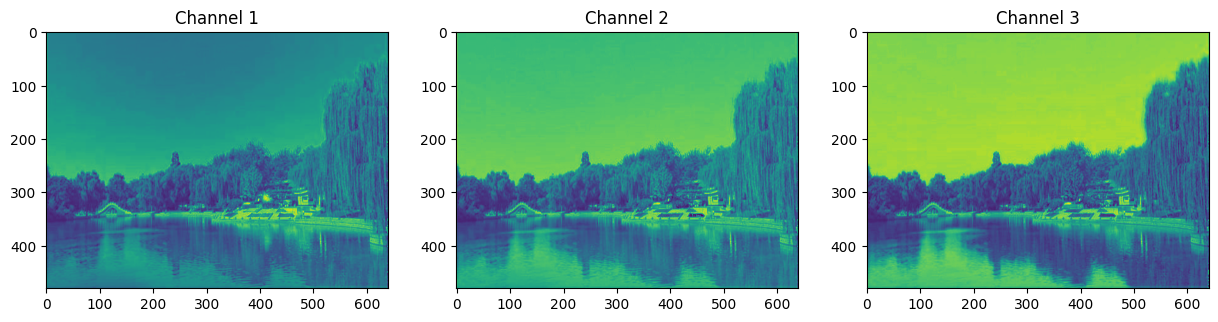

MSE(q_add_relu,q_add):0.0


In [ ]:
q_add = q_add_fun(q_sub,Ssub_out,Zsub_out,Sadd_out,Zadd_out)
print(f"q_add:\n{q_add}")
q_add_relu = Q_Relu(Zadd_out,Sadd_out,Zadd_out,Sadd_out,q_add)
print(f"q_add_relu:\n{q_add_relu}")
array_show(q_add_relu)
visualize_channels_int8(q_add_relu)
print(f"MSE(q_add_relu,q_add):{MSE(q_add_relu,q_add)}")

解量化+add+量化计算

In [ ]:
print(f"hazy_image.dtype:{hazy_image.dtype}")
print(f"dq_sub_quant.dtype:{dq_sub_quant.dtype}")

hazy_image.dtype:float64
dq_sub_quant.dtype:float64


In [ ]:
dq_add_quant = dq_sub_quant+np.array(1).astype(np.float32)
print(f"dq_add_quant:{dq_add_quant}")
print(f"dq_add_quant.shape:{dq_add_quant.shape}")
print(f"dq_add_quant.dtype:{dq_add_quant.dtype}")

dq_add_quant:[[[[ 0.3672057   0.39958122  0.42901349 ...  0.47065764  0.43675884
     0.33767011]
   [ 0.45550258  0.46433226  0.4466729  ...  0.44979684  0.51498678
     0.33506254]
   [ 0.45255934  0.51142394  0.53496979 ...  0.46544241  0.56974632
     0.33506254]
   ...
   [ 0.42382415  0.44481399  0.49505547 ...  0.48849772  0.52650154
     0.04092035]
   [ 0.39384966  0.44259368  0.47951312 ...  0.60312877  0.59806846
     0.10432887]
   [ 0.26396033  0.38685302  0.36890965 ...  0.51914344  0.42638007
     0.10665245]]

  [[ 0.56806817  0.62228556  0.62590007 ...  0.6463994   0.66127044
     0.57865349]
   [ 0.6313218   0.66204497  0.66927396 ...  0.65300876  0.70753596
     0.57865349]
   [ 0.65300876  0.71626235  0.70541889 ...  0.70918827  0.70588361
     0.57865349]
   ...
   [ 0.52660478  0.61983289  0.64810337 ...  0.53698355  0.49461654
     0.11024112]
   [ 0.50677674  0.58257777  0.61343005 ...  0.65324112  0.56755182
     0.17145513]
   [ 0.48199162  0.54132095  0.54620

In [ ]:
q_add_quant = quantization_int8(dq_add_quant,Sadd_out,Zadd_out)
print(f"q_add_quant:{q_add_quant}")
print(f"q_add_quant.shape:{q_add_quant.shape}")
print(f"q_add_quant.dtype:{q_add_quant.dtype}")

q_add_quant:[[[[ -34  -26  -19 ...   -8  -17  -42]
   [ -12  -10  -14 ...  -13    3  -43]
   [ -13    2    8 ...   -9   17  -43]
   ...
   [ -20  -15   -2 ...   -3    6 -118]
   [ -28  -15   -6 ...   26   24 -101]
   [ -61  -29  -34 ...    4  -19 -101]]

  [[  17   31   32 ...   37   41   20]
   [  33   41   43 ...   39   52   20]
   [  39   55   52 ...   53   52   20]
   ...
   [   6   30   37 ...    9   -2 -100]
   [   1   21   28 ...   39   17  -84]
   [  -5   10   11 ...   18  -17 -100]]

  [[  64   68   69 ...   76   79   68]
   [  73   79   77 ...   79   83   67]
   [  75   83   87 ...   91   80   69]
   ...
   [  24   53   51 ...    9  -48 -125]
   [  25   49   41 ...   23  -14 -106]
   [  15   28   30 ...  -22  -43 -128]]]]
q_add_quant.shape:(1, 3, 480, 640)
q_add_quant.dtype:int8


In [ ]:
q_add_relu_quant = Q_Relu(Zadd_out,Sadd_out,Zadd_out,Sadd_out,q_add_quant)
print(f"q_add_relu_quant:{q_add_relu_quant}")
print(f"q_add_relu_quant.shape:{q_add_relu_quant.shape}")
print(f"q_add_relu_quant.dtype:{q_add_relu_quant.dtype}")

q_add_relu_quant:[[[[ -34  -26  -19 ...   -8  -17  -42]
   [ -12  -10  -14 ...  -13    3  -43]
   [ -13    2    8 ...   -9   17  -43]
   ...
   [ -20  -15   -2 ...   -3    6 -118]
   [ -28  -15   -6 ...   26   24 -101]
   [ -61  -29  -34 ...    4  -19 -101]]

  [[  17   31   32 ...   37   41   20]
   [  33   41   43 ...   39   52   20]
   [  39   55   52 ...   53   52   20]
   ...
   [   6   30   37 ...    9   -2 -100]
   [   1   21   28 ...   39   17  -84]
   [  -5   10   11 ...   18  -17 -100]]

  [[  64   68   69 ...   76   79   68]
   [  73   79   77 ...   79   83   67]
   [  75   83   87 ...   91   80   69]
   ...
   [  24   53   51 ...    9  -48 -125]
   [  25   49   41 ...   23  -14 -106]
   [  15   28   30 ...  -22  -43 -128]]]]
q_add_relu_quant.shape:(1, 3, 480, 640)
q_add_relu_quant.dtype:int8


add近似计算误差

In [ ]:
print(f"MSE(q_add_quant,q_add):{MSE(q_add_quant,q_add)/100}")
print(f"MSE(q_add_relu_quant,q_add_relu):{MSE(q_add_relu_quant,q_add_relu)/100}")

MSE(q_add_quant,q_add):0.004738595920138889
MSE(q_add_relu_quant,q_add_relu):0.004738595920138889


INT8模型输出

In [ ]:
def array_show_int8(array):
    deahze_img = array.astype(np.uint8)
    print(f"deahze_img.shape:{deahze_img.shape:}")
    deahze_img = np.squeeze(deahze_img)
    print(f"deahze_img.shape after:{deahze_img.shape:}")
    img = Image.fromarray(deahze_img.transpose(1,2,0))
    img.show()
q_img_out= q_add_relu+128
print(f"q_img_out:{q_img_out}")
print(f"q_img_out.shape:{q_img_out.shape}")
print(f"q_img_out.dtype:{q_img_out.dtype}")
array_show_int8(q_img_out)

q_img_out:[[[[ 95 102 110 ... 121 111  86]
   [116 119 114 ... 115 131  86]
   [115 130 136 ... 119 146  86]
   ...
   [107 114 126 ... 124 134  11]
   [101 114 122 ... 154 154  27]
   [ 67  99  95 ... 132 109  26]]

  [[145 159 160 ... 165 169 147]
   [161 169 171 ... 166 180 147]
   [167 182 180 ... 181 180 147]
   ...
   [135 159 166 ... 137 126  27]
   [129 149 156 ... 167 145  43]
   [124 139 140 ... 146 111  27]]

  [[192 195 197 ... 205 207 196]
   [201 207 205 ... 209 211 195]
   [204 211 215 ... 219 209 197]
   ...
   [151 182 180 ... 137  80   2]
   [154 177 169 ... 151 114  22]
   [142 156 159 ... 106  85 246]]]]
q_img_out.shape:(1, 3, 480, 640)
q_img_out.dtype:int16
deahze_img.shape:(1, 3, 480, 640)
deahze_img.shape after:(3, 480, 640)


FP32计算

In [ ]:
out_mul = r_relu5 * hazy_image
print(f"out_mul:{out_mul}")
print(f"out_mul.shape:{out_mul.shape:}")
# array_show(out_mul)

out_mul:[[[[0.55878808 0.62362609 0.67522401 ... 0.73640698 0.78813619
    0.68718845]
   [0.62043327 0.68605743 0.69161756 ... 0.79988162 0.80615058
    0.83212091]
   [0.65543501 0.67044842 0.68797308 ... 0.78504719 0.8074213
    0.82328667]
   ...
   [0.60976285 0.60756939 0.62034337 ... 0.61832146 0.56562897
    0.49439468]
   [0.60938437 0.62698887 0.64061626 ... 0.62449775 0.56845082
    0.48359435]
   [0.53248515 0.58571034 0.59879203 ... 0.56632671 0.50554114
    0.45972932]]

  [[0.67481507 0.82125963 0.85611244 ... 0.89567374 0.88478863
    0.88445282]
   [0.74719252 0.87575937 0.87462988 ... 0.98726165 0.96138929
    1.06778813]
   [0.80626816 0.8808677  0.87707634 ... 0.95188052 0.93721039
    1.08452949]
   ...
   [0.75608512 0.75284169 0.75896934 ... 0.64886039 0.56936732
    0.50675019]
   [0.71736367 0.75608613 0.78474833 ... 0.65543606 0.57748269
    0.51739091]
   [0.71063827 0.69161591 0.75713471 ... 0.58568114 0.51439628
    0.44546356]]

  [[0.71713521 0.89845743 0

In [ ]:
out_sub = out_mul - r_relu5
# array_show(out_sub)
print(f"out_sub:{out_sub}")
print(f"out_sub.shape:{out_sub.shape:}")

out_sub:[[[[-0.45178611 -0.50420832 -0.5459258  ... -0.48296822 -0.51689451
    -0.45068853]
   [-0.5016269  -0.55468473 -0.55918016 ... -0.52459769 -0.52870915
    -0.54574164]
   [-0.52992618 -0.54206468 -0.55623356 ... -0.51486861 -0.52954254
    -0.53994775]
   ...
   [-0.62428101 -0.6123534  -0.61549694 ... -0.61349083 -0.68859179
    -0.68383564]
   [-0.62389352 -0.62209052 -0.6257182  ... -0.60997454 -0.6811609
    -0.65822564]
   [-0.54516337 -0.58113448 -0.58486664 ... -0.54454492 -0.59627929
    -0.61578422]]

  [[-0.25533543 -0.31074689 -0.32393444 ... -0.30012104 -0.29647368
    -0.29636115]
   [-0.28272149 -0.33136841 -0.33094104 ... -0.33081019 -0.32214091
    -0.35779288]
   [-0.30507444 -0.33330129 -0.33186672 ... -0.31895473 -0.31403908
    -0.36340255]
   ...
   [-0.45650422 -0.44699975 -0.44312496 ... -0.59519524 -0.64053824
    -0.64701141]
   [-0.43312523 -0.44144159 -0.45050367 ... -0.59184898 -0.63952629
    -0.65017265]
   [-0.42906461 -0.4038006  -0.43465141 ..

In [ ]:
out_add = out_sub+1
array_show(out_add)
print(f"out_add:{out_add}")
print(f"out_add.shape:{out_add.shape:}")

deahze_img.shape:(1, 3, 480, 640)
deahze_img.shape after:(3, 480, 640)
out_add:[[[[0.54821389 0.49579168 0.4540742  ... 0.51703178 0.48310549
    0.54931147]
   [0.4983731  0.44531527 0.44081984 ... 0.47540231 0.47129085
    0.45425836]
   [0.47007382 0.45793532 0.44376644 ... 0.48513139 0.47045746
    0.46005225]
   ...
   [0.37571899 0.3876466  0.38450306 ... 0.38650917 0.31140821
    0.31616436]
   [0.37610648 0.37790948 0.3742818  ... 0.39002546 0.3188391
    0.34177436]
   [0.45483663 0.41886552 0.41513336 ... 0.45545508 0.40372071
    0.38421578]]

  [[0.74466457 0.68925311 0.67606556 ... 0.69987896 0.70352632
    0.70363885]
   [0.71727851 0.66863159 0.66905896 ... 0.66918981 0.67785909
    0.64220712]
   [0.69492556 0.66669871 0.66813328 ... 0.68104527 0.68596092
    0.63659745]
   ...
   [0.54349578 0.55300025 0.55687504 ... 0.40480476 0.35946176
    0.35298859]
   [0.56687477 0.55855841 0.54949633 ... 0.40815102 0.36047371
    0.34982735]
   [0.57093539 0.5961994  0.56534859 


(eog:13886): EOG-WARNING **: 16:34:39.350: Couldn't load icon: Icon 'image-loading' not present in theme Adwaita


计算FP32与INT8推理偏差

In [ ]:
print(f"MSE(out_mul,dq_mul):{MSE(out_mul,dq_mul_quant)}")
print(f"MSE(out_sub,dq_sub):{MSE(out_sub,dq_sub_quant)}")
print(f"MSE(out_add,dq_add):{MSE(out_add,dq_add_quant)}")

MSE(out_mul,dq_mul):0.010721839681383514
MSE(out_sub,dq_sub):0.007702878467471725
MSE(out_add,dq_add):0.007702878467471725


加载无雾图像用于评估FP32模型和INT8模型

In [ ]:
# img_path="./query_hazy_images/OTS_2633.jpg"
clear_input_image = Image.open(clear_img_path)#图像加载
clear_input_image = clear_input_image.resize((640, 480))
clear_input_image.show()
clear_image = (np.asarray(clear_input_image))
clear_image = clear_image.transpose(2,0,1)#HWC -> CHW
clear_image = np.expand_dims(clear_image,axis=0)#增加一个新的维度batch_size (batch_size,C,H,W)
clear_image = clear_image / 255
# print(f"haze_image.shape:{clear_image.shape}")
# print(f"haze_image:{clear_image}")

In [ ]:
print(f"MSE(clear_image,hazy_image):{MSE(clear_image,hazy_image)}")#原图
print(f"MSE(clear_image,dq_add):{MSE(clear_image,dq_add_quant)}")#INT8
print(f"MSE(out_add,clear_image):{MSE(out_add,clear_image)}")#FP32

MSE(clear_image,hazy_image):0.11907016782407408
MSE(clear_image,dq_add):0.03345739022117972
MSE(out_add,clear_image):0.03607075699992308



(eog:13886): EOG-WARNING **: 16:34:39.600: Couldn't load icon: Icon 'image-loading' not present in theme Adwaita


计算FP32和INT8的SSIM和PSNR

In [ ]:
gray_ssim_fp32,average_ssim_fp32 = SSIM(out_add,clear_image)
gray_ssim_int8,average_ssim_int8 = SSIM(clear_image,dq_add_quant)
gray_psnr_fp32,average_psnr_fp32 = PSNR(out_add,clear_image)
gray_psnr_int8,average_psnr_int8 = PSNR(clear_image,dq_add_quant)
print(f"FP32:\ngray_ssim_fp32,average_ssim_fp32 = \t{gray_ssim_fp32}\t{average_ssim_fp32}\ngray_psnr_fp32,average_psnr_fp32 = \t{gray_psnr_fp32}\t{average_psnr_fp32}\n")
print(f"INT8:\ngray_ssim_int8,average_ssim_int8 = \t{gray_ssim_int8}\t{average_ssim_int8}\ngray_psnr_int8,average_psnr_int8 = \t{gray_psnr_int8}\t{average_psnr_int8}\n")



(eog:13886): EOG-WARNING **: 16:34:39.786: Couldn't load icon: Icon 'image-loading' not present in theme Adwaita


FP32:
gray_ssim_fp32,average_ssim_fp32 = 	0.9999985769407489	0.9999984821083153
gray_psnr_fp32,average_psnr_fp32 = 	90.7005265084911	90.42329250317867

INT8:
gray_ssim_int8,average_ssim_int8 = 	0.9999985769407489	0.9999984821083153
gray_psnr_int8,average_psnr_int8 = 	90.7005265084911	90.42329250317867



In [ ]:
from numpy.linalg import norm

print(f"norm(out_add-clear_image):{norm(clear_image-out_add)}")
print(f"norm(dq_add-clear_image):{norm(clear_image-dq_add_quant)}")

norm(out_add-clear_image):45.138275768441794
norm(dq_add-clear_image):41.45696961655972
